In [ ]:
#=========================================================
# write_dictionaries.py
# Author: McKenna W. Stanford
# Date Created: 01/05/2024
# Utility: Writes dictionaries for each run
#=========================================================

In [15]:
#=======================================
# Imports
#=======================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from metpy.calc import dry_lapse, lcl, moist_lapse
import metpy.calc as mpcalc
from metpy.units import units
import scipy
from dask.distributed import Client
import h5py
from scipy.integrate import cumulative_trapezoid as scitrapz
from IPython.display import display, clear_output
import time

In [16]:
#=======================================
# Diagnostics Parameters
#=======================================
space = '    '
#=======================================
# Functions
#=======================================
def print_diag(key,var):
    print(key)
    print(space,'Shape:',np.shape(var))
    print(space,'Max:',np.max(var))
    print(space,'Min:',np.min(var))
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [26]:
#=======================================
# Get files
#=======================================
sim_name = 'bin'
path_3d = '/discover/nobackup/mwstanfo/dharma_3d/'
files_3d = sorted(glob.glob(path_3d+sim_name+'/dharma_3d_'+sim_name+'*.nc'))
#files_3d = sorted(glob.glob(path_3d+sim_name+'/dharma_BIN_TURB_10X/dharma_3d_'+sim_name+'*.nc'))
files_3d = files_3d[-19:]
print(files_3d)

['/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_032400.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_033000.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_033600.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_034200.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_034800.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_035400.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_036000.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_036600.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_037200.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_037800.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_038400.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_039000.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_039600.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin/dharma_3d_bin_040200.nc', '/discover/nobackup/mwstanfo/dhar

# Dictionaries for 3D variables and cloud-top variables

In [27]:
def main(file):
    """
    For a single file (i.e., time), read in some variables and
    calculate water contents, integrated water contents (water paths),
    and then send variables to the 'calc_cth' function.
    
    Returns a dictionary with all desired variables.
    """
    
    #print('Reading in file...')
    # Read in file
    ncfile = xarray.open_dataset(file,decode_times=False)
    rho = ncfile['rhobar'].values # in kg/m^3
    ql = ncfile['ql'].values # in kg/kg
    qnl = ncfile['nl'].values # in cm-3
    qnl_lt_100um = ncfile['nl_int_lt_100'].values # in cm-3
    reff_l = ncfile['reff_l'].values # in cm-3
    reff_l_lt_100um = ncfile['reff_l_lt_100'].values # in cm-3
    
    z = ncfile['zt'].values # in m
    w = ncfile['w_interp'].values # in m
    xtime = ncfile['time'].values[0] # seconds
    temp = ncfile['temperature'].values-273.15 # deg C
    nx = ncfile.dims['nx']
    ny = ncfile.dims['ny']
    nz = ncfile.dims['nzt']
    x = ncfile.coords['x'].values
    y = ncfile.coords['y'].values
    zw = ncfile['zw'].values
    dz = np.diff(zw)
    num_bins = 50
    
    keys = list(ncfile.keys())
    liq_num_arr = []
    for key in keys:
        if 'liq_num' in key:
            liq_num_arr.append(ncfile[key].values)
        
    liq_num_arr = np.array(liq_num_arr)*1.e3*rho*1.e-6 # /cc
    
    lwc = ql*rho*1.e3
    lwp = np.trapezoid(lwc,z) # g/m^2
    
    dharma_dict = {'ql':ql,\
                   'rho':rho,\
                   'qnl':qnl,\
                   'qnl_lt_100um':qnl_lt_100um,\
                   'z':z,\
                   'w':w,\
                   'time':xtime,\
                   'temp':temp,\
                   'nx':nx,\
                   'ny':ny,\
                   'nz':nz,\
                   'x':x,\
                   'y':y,\
                   'reff_l':reff_l,\
                   'reff_l_lt_100um':reff_l_lt_100um,\
                   'dz':dz,\
                   'num_bins':num_bins,\
                   'lwp':lwp,\
                   'liq_num':liq_num_arr,\
                  }
    
    
    return dharma_dict

In [28]:
def calc_r_moments_opd(dharma_dict):

    ql = dharma_dict['ql']
    #qnl = dharma_dict['qnl']
    #qnl_lt_100um = dharma_dict['qnl_lt_100um']
    #reff_l = dharma_dict['reff_l']
    #reff_l_lt_100um = dharma_dict['reff_l_lt_100um']
    rho = dharma_dict['z']
    nx = dharma_dict['nx']
    ny = dharma_dict['ny']
    nz = dharma_dict['nz']
    dz = dharma_dict['dz']
    z = dharma_dict['z']
    liq_num = dharma_dict['liq_num']

    qsmall = 1.e-9
    #qsmall = 1.e-4
    
    #==============================================
    # r moments
    #==============================================
    liq_id = np.where(ql > qsmall)
    print(np.shape(liq_id))
   

    rad = np.array([1.0908325e+00, 1.2889994e+00, 1.5231664e+00, 1.7998737e+00,
       2.1268492e+00, 2.5132246e+00, 2.9697914e+00, 3.5093009e+00,
       4.1468210e+00, 4.9001560e+00, 5.7903466e+00, 6.8422546e+00,
       8.0852575e+00, 9.5540724e+00, 1.1289721e+01, 1.3340674e+01,
       1.5764219e+01, 1.8628036e+01, 2.2012114e+01, 2.6010962e+01,
       3.0736261e+01, 3.6319988e+01, 4.2918083e+01, 5.0714832e+01,
       5.9927982e+01, 7.0814842e+01, 8.3679474e+01, 9.8881165e+01,
       1.1684450e+02, 1.3807112e+02, 1.6315393e+02, 1.9279343e+02,
       2.2781737e+02, 2.6920398e+02, 3.1810913e+02, 3.7589862e+02,
       4.4418655e+02, 5.2488007e+02, 6.2023279e+02, 7.3290778e+02,
       8.6605206e+02, 1.0233841e+03, 1.2092980e+03, 1.4289858e+03,
       1.6885837e+03, 1.9953414e+03, 2.3578269e+03, 2.7861631e+03,
       3.2923137e+03, 3.8904143e+03])*1.e-6 # meters
        
    rbound = np.array([9.9999958e-01, 1.1816654e+00, 1.3963336e+00, 1.6499995e+00,
   1.9497479e+00, 2.3039503e+00, 2.7224991e+00, 3.2170839e+00,
   3.8015180e+00, 4.4921236e+00, 5.3081889e+00, 6.2725048e+00,
   7.4120040e+00, 8.7585115e+00, 1.0349633e+01, 1.2229807e+01,
   1.4451543e+01, 1.7076893e+01, 2.0179180e+01, 2.3845047e+01,
   2.8176876e+01, 3.3295647e+01, 3.9344326e+01, 4.6491840e+01,
   5.4937820e+01, 6.4918144e+01, 7.6711540e+01, 9.0647408e+01,
   1.0711493e+02, 1.2657405e+02, 1.4956821e+02, 1.7673964e+02,
   2.0884718e+02, 2.4678755e+02, 2.9162039e+02, 3.4459784e+02,
   4.0719946e+02, 4.8117365e+02, 5.6858643e+02, 6.7187915e+02,
   7.9393652e+02, 9.3816766e+02, 1.1086006e+03, 1.3099954e+03,
   1.5479766e+03, 1.8291908e+03, 2.1614922e+03, 2.5541611e+03,
   3.0181650e+03, 3.5664624e+03, 4.2143662e+03])*1.e-6 # meters
    dr = np.diff(rbound)

    num_r = len(rad)    
    rad_midbins = rad.copy()    
    
    
    id_lt_100um = np.squeeze(np.where(rad_midbins*1.e6 <= 50.))
    id_lt_200um = np.squeeze(np.where(rad_midbins*1.e6 <= 100.))
        
    reff_l = np.zeros((nx,ny,nz))-999.
    reff_l_lt_100um = np.zeros((nx,ny,nz))-999.
    reff_l_lt_200um = np.zeros((nx,ny,nz))-999.
    
    veff_l = np.zeros((nx,ny,nz))-999.
    veff_l_lt_100um = np.zeros((nx,ny,nz))-999.
    veff_l_lt_200um = np.zeros((nx,ny,nz))-999.
    
    qnl = np.zeros((nx,ny,nz))
    qnl_lt_100um = np.zeros((nx,ny,nz))
    qnl_lt_200um = np.zeros((nx,ny,nz))
    

    r4_l = np.zeros((nx,ny,nz))-999.
    r3_l = np.zeros((nx,ny,nz))-999.
    r2_l = np.zeros((nx,ny,nz))-999.
    r4_l_lt_100um = np.zeros((nx,ny,nz))-999.
    r3_l_lt_100um = np.zeros((nx,ny,nz))-999.
    r2_l_lt_100um = np.zeros((nx,ny,nz))-999.
    r4_l_lt_200um = np.zeros((nx,ny,nz))-999.
    r3_l_lt_200um = np.zeros((nx,ny,nz))-999.
    r2_l_lt_200um = np.zeros((nx,ny,nz))-999.
    

    
    opd = np.zeros((nx,ny,nz))
    opd_lt_100um = np.zeros((nx,ny,nz))
    opd_lt_200um = np.zeros((nx,ny,nz))
    
    ext = np.zeros((nx,ny,nz))
    ext_lt_100um = np.zeros((nx,ny,nz))
    ext_lt_200um = np.zeros((nx,ny,nz))

    
    len_liq_id = len(liq_id[0])

    for ii in range(len_liq_id):
        
        i_id = liq_id[0][ii]
        j_id = liq_id[1][ii]
        k_id = liq_id[2][ii]
        
        dN = liq_num[:,i_id,j_id,k_id]*1.e6 # /m3
        
        # Convert to /m4
        dNdr = dN/dr

        r4_l[i_id,j_id,k_id] = np.trapezoid((dNdr*rad_midbins**4.),rad_midbins)
        r3_l[i_id,j_id,k_id] = np.trapezoid((dNdr*rad_midbins**3.),rad_midbins)
        r2_l[i_id,j_id,k_id] = np.trapezoid((dNdr*rad_midbins**2.),rad_midbins)
        r4_l_lt_100um[i_id,j_id,k_id] = np.trapezoid((dNdr[id_lt_100um]*rad_midbins[id_lt_100um]**4.),rad_midbins[id_lt_100um])
        r3_l_lt_100um[i_id,j_id,k_id] = np.trapezoid((dNdr[id_lt_100um]*rad_midbins[id_lt_100um]**3.),rad_midbins[id_lt_100um])
        r2_l_lt_100um[i_id,j_id,k_id] = np.trapezoid((dNdr[id_lt_100um]*rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
        r4_l_lt_200um[i_id,j_id,k_id] = np.trapezoid((dNdr[id_lt_200um]*rad_midbins[id_lt_200um]**4.),rad_midbins[id_lt_200um])
        r3_l_lt_200um[i_id,j_id,k_id] = np.trapezoid((dNdr[id_lt_200um]*rad_midbins[id_lt_200um]**3.),rad_midbins[id_lt_200um])
        r2_l_lt_200um[i_id,j_id,k_id] = np.trapezoid((dNdr[id_lt_200um]*rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])
        

            
        if r2_l[i_id,j_id,k_id] == 0.:
            reff_l[i_id,j_id,k_id] = 0.
            veff_l[i_id,j_id,k_id] = 0.
        else:
            reff_l[i_id,j_id,k_id] = r3_l[i_id,j_id,k_id]/r2_l[i_id,j_id,k_id]*1.e6 # um
            veff_l[i_id,j_id,k_id] = (r4_l[i_id,j_id,k_id]*r2_l[i_id,j_id,k_id])/(r3_l[i_id,j_id,k_id]**2.) - 1.
            
        if r2_l_lt_100um[i_id,j_id,k_id] == 0.:
            reff_l_lt_100um[i_id,j_id,k_id] = 0.
            veff_l_lt_100um[i_id,j_id,k_id] = 0.
        else:
            reff_l_lt_100um[i_id,j_id,k_id] = r3_l_lt_100um[i_id,j_id,k_id]/r2_l_lt_100um[i_id,j_id,k_id]*1.e6 # um
            veff_l_lt_100um[i_id,j_id,k_id] = (r4_l_lt_100um[i_id,j_id,k_id]*r2_l_lt_100um[i_id,j_id,k_id])/(r3_l_lt_100um[i_id,j_id,k_id]**2.)-1.
        
        if r2_l_lt_200um[i_id,j_id,k_id] == 0.:
            reff_l_lt_200um[i_id,j_id,k_id] = 0.
            veff_l_lt_200um[i_id,j_id,k_id] = 0.
        else:
            reff_l_lt_200um[i_id,j_id,k_id] = r3_l_lt_200um[i_id,j_id,k_id]/r2_l_lt_200um[i_id,j_id,k_id]*1.e6 # um
            veff_l_lt_200um[i_id,j_id,k_id] = (r4_l_lt_200um[i_id,j_id,k_id]*r2_l_lt_200um[i_id,j_id,k_id])/(r3_l_lt_200um[i_id,j_id,k_id]**2.)-1.

        
        
        qnl[i_id,j_id,k_id] = np.trapezoid(dNdr,rad_midbins)*1.e-6
        qnl_lt_100um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        qnl_lt_200um[i_id,j_id,k_id] = np.trapezoid(dNdr[id_lt_200um],rad_midbins[id_lt_200um])*1.e-6
        
        opd[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr*dz[k_id]*(rad_midbins**2.),rad_midbins)
        opd_lt_100um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(dNdr[id_lt_100um])*dz[k_id]*(rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
        opd_lt_200um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(dNdr[id_lt_200um])*dz[k_id]*(rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])
        
        ext[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*dNdr*(rad_midbins**2.),rad_midbins)
        ext_lt_100um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(dNdr[id_lt_100um])*(rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])
        ext_lt_200um[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(dNdr[id_lt_200um])*(rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])        
        
        
    dharma_dict['reff_l'] = reff_l
    dharma_dict['veff_l'] = veff_l
    dharma_dict['qnl'] = qnl
    dharma_dict['qnl_lt_100um'] = qnl_lt_100um
    dharma_dict['qnl_lt_200um'] = qnl_lt_200um
    dharma_dict['opd_lt_100um'] = opd_lt_100um
    dharma_dict['opd_lt_200um'] = opd_lt_200um
    dharma_dict['ext_lt_100um'] = ext_lt_100um
    dharma_dict['ext_lt_200um'] = ext_lt_200um
    dharma_dict['r4_l'] = r4_l
    dharma_dict['r3_l'] = r3_l
    dharma_dict['r2_l'] = r2_l
    dharma_dict['r4_l_lt_100um'] = r4_l_lt_100um
    dharma_dict['r3_l_lt_100um'] = r3_l_lt_100um
    dharma_dict['r2_l_lt_100um'] = r2_l_lt_100um
    dharma_dict['r4_l_lt_200um'] = r4_l_lt_200um
    dharma_dict['r3_l_lt_200um'] = r3_l_lt_200um
    dharma_dict['r2_l_lt_200um'] = r2_l_lt_200um
    dharma_dict['reff_l_lt_100um'] = reff_l_lt_100um
    dharma_dict['veff_l_lt_100um'] = veff_l_lt_100um
    dharma_dict['reff_l_lt_200um'] = reff_l_lt_200um
    dharma_dict['veff_l_lt_200um'] = veff_l_lt_200um
    dharma_dict['opd'] = opd
    dharma_dict['ext'] = ext
    dharma_dict['op_thick'] = np.sum(opd,axis=2)
        
    return dharma_dict

In [29]:
#dharma_dict = calc_r_moments_opd(dharma_dict)

In [30]:
def calc_cth(dharma_dict):
    """
    Calculate cloud top height by integrated optical depth downward from
    10 km using only cloud liquid water (i.e., no rain or ice).

    # Returns cloud top height (CTH) as well as the cloud droplet number concentration,
    # the cloud effective radius, and the cloud top temperature.
    """    

    opd = dharma_dict['opd']
    opd_lt_100um = dharma_dict['opd_lt_100um']
    opd_lt_200um = dharma_dict['opd_lt_200um']
    reff_l = dharma_dict['reff_l']
    reff_l_lt_100um = dharma_dict['reff_l_lt_100um']
    reff_l_lt_200um = dharma_dict['reff_l_lt_200um']
    r4_l = dharma_dict['r4_l']
    r3_l = dharma_dict['r3_l']
    r2_l = dharma_dict['r2_l']
    r4_l_lt_100um = dharma_dict['r4_l_lt_100um']
    r3_l_lt_100um = dharma_dict['r3_l_lt_100um']
    r2_l_lt_100um = dharma_dict['r2_l_lt_100um']
    r4_l_lt_200um = dharma_dict['r4_l_lt_200um']
    r3_l_lt_200um = dharma_dict['r3_l_lt_200um']
    r2_l_lt_200um = dharma_dict['r2_l_lt_200um']
    veff_l = dharma_dict['veff_l']
    veff_l_lt_100um = dharma_dict['veff_l_lt_100um']
    veff_l_lt_200um = dharma_dict['veff_l_lt_200um']

    qnl_lt_100um = dharma_dict['qnl_lt_100um']
    qnl_lt_200um = dharma_dict['qnl_lt_200um']
    qnl = dharma_dict['qnl']
    ql = dharma_dict['ql']
    rho = dharma_dict['rho']
    z = dharma_dict['z']
    temp = dharma_dict['temp']
    nx = dharma_dict['nx']
    ny = dharma_dict['ny']
    ext = dharma_dict['ext']
    ext_lt_100um = dharma_dict['ext_lt_100um']
    ext_lt_200um = dharma_dict['ext_lt_200um']
    dz = dharma_dict['dz']



    dumid = np.where(z <= 10000.)
    z = z[dumid]
    ql = ql[:,:,dumid]
    qnl = qnl[:,:,dumid]
    qnl_lt_100um = qnl_lt_100um[:,:,dumid]
    qnl_lt_200um = qnl_lt_200um[:,:,dumid]
    temp = temp[:,:,dumid]
    rho = rho[dumid]
    reff_l = reff_l[:,:,dumid]
    reff_l_lt_100um = reff_l_lt_100um[:,:,dumid]
    reff_l_lt_200um = reff_l_lt_200um[:,:,dumid]
    opd = opd[:,:,dumid]
    opd_lt_100um = opd_lt_100um[:,:,dumid]
    opd_lt_200um = opd_lt_200um[:,:,dumid]
    ext = ext[:,:,dumid]
    ext_lt_100um = ext_lt_100um[:,:,dumid]
    ext_lt_200um = ext_lt_200um[:,:,dumid]
    r4_l = r4_l[:,:,dumid]
    r3_l = r3_l[:,:,dumid]
    r2_l = r2_l[:,:,dumid]
    r4_l_lt_100um = r4_l_lt_100um[:,:,dumid]
    r3_l_lt_100um = r3_l_lt_100um[:,:,dumid]
    r2_l_lt_100um = r2_l_lt_100um[:,:,dumid]
    r4_l_lt_200um = r4_l_lt_200um[:,:,dumid]
    r3_l_lt_200um = r3_l_lt_200um[:,:,dumid]
    r2_l_lt_200um = r2_l_lt_200um[:,:,dumid]

    veff_l = veff_l[:,:,dumid]
    veff_l_lt_100um = veff_l_lt_100um[:,:,dumid]
    veff_l_lt_200um = veff_l_lt_200um[:,:,dumid]

    dz = dz[dumid]
    nz = len(z)

    cth = np.zeros((nx,ny))-999.
    ctt = np.zeros((nx,ny))-999.
    ct_qcloud = np.zeros((nx,ny))-999.
    ct_qrain = np.zeros((nx,ny))-999.
    ct_ql = np.zeros((nx,ny))-999.
    ct_qncloud = np.zeros((nx,ny))-999.
    ct_qnrain = np.zeros((nx,ny))-999.
    ct_qnl = np.zeros((nx,ny))-999.
    ct_qnl_lt_100um = np.zeros((nx,ny))-999.
    ct_qnl_lt_200um = np.zeros((nx,ny))-999.
    ct_reff_c = np.zeros((nx,ny))-999.
    ct_reff_l = np.zeros((nx,ny))-999.
    ct_reff_l_lt_100um = np.zeros((nx,ny))-999.
    ct_reff_l_lt_200um = np.zeros((nx,ny))-999.
    ct_rho = np.zeros((nx,ny))-999.
    ct_opd = np.zeros((nx,ny))-999.
    ct_ext = np.zeros((nx,ny))-999.
    ct_veff_l = np.zeros((nx,ny))-999.
    ct_veff_l_lt_100um = np.zeros((nx,ny))-999.
    ct_veff_l_lt_200um = np.zeros((nx,ny))-999.

    min_thresh = 1.e-9 # kg/kg (equivalent to 1.e-6 g/kg)
    opt_thresh = 1

    for ii in range(nx):
        for jj in range(ny):
            single_prof_ql = np.squeeze(np.flip(ql[ii,jj,:]))
            single_prof_qnl = np.squeeze(np.flip(qnl[ii,jj,:]))
            single_prof_qnl_lt_100um = np.squeeze(np.flip(qnl_lt_100um[ii,jj,:]))
            single_prof_qnl_lt_200um = np.squeeze(np.flip(qnl_lt_200um[ii,jj,:]))
            
            
            #if np.max(single_prof_ql) < min_thresh:
            if (np.max(single_prof_ql) < min_thresh) or (np.max(single_prof_qnl_lt_200um) < 1.):
            #if np.max(single_prof_qcloud) < min_thresh:
                continue
            else:
                pass

            single_prof_z = np.squeeze(np.flip(z))
            single_prof_rho = np.squeeze(np.flip(rho))
            single_prof_temp = np.squeeze(np.flip(temp[ii,jj,:]))
            single_prof_reff_l = np.squeeze(np.flip(reff_l[ii,jj,:]))
            single_prof_reff_l_lt_100um = np.squeeze(np.flip(reff_l_lt_100um[ii,jj,:]))
            single_prof_reff_l_lt_200um = np.squeeze(np.flip(reff_l_lt_200um[ii,jj,:]))
            single_prof_opd = np.squeeze(np.flip(opd[ii,jj,:]))
            single_prof_opd_lt_100um = np.squeeze(np.flip(opd_lt_100um[ii,jj,:]))
            single_prof_opd_lt_200um = np.squeeze(np.flip(opd_lt_200um[ii,jj,:]))
            single_prof_ext = np.squeeze(np.flip(ext[ii,jj,:]))
            single_prof_ext_lt_100um = np.squeeze(np.flip(ext_lt_100um[ii,jj,:]))
            single_prof_ext_lt_200um = np.squeeze(np.flip(ext_lt_200um[ii,jj,:]))
            single_prof_dz = np.squeeze(np.flip(dz))
            single_prof_r4_l = np.squeeze(np.flip(r4_l[ii,jj,:]))
            single_prof_r3_l = np.squeeze(np.flip(r3_l[ii,jj,:]))
            single_prof_r2_l = np.squeeze(np.flip(r2_l[ii,jj,:]))
            single_prof_r4_l_lt_100um = np.squeeze(np.flip(r4_l_lt_100um[ii,jj,:]))
            single_prof_r3_l_lt_100um = np.squeeze(np.flip(r3_l_lt_100um[ii,jj,:]))
            single_prof_r2_l_lt_100um = np.squeeze(np.flip(r2_l_lt_100um[ii,jj,:]))
            single_prof_r4_l_lt_200um = np.squeeze(np.flip(r4_l_lt_200um[ii,jj,:]))
            single_prof_r3_l_lt_200um = np.squeeze(np.flip(r3_l_lt_200um[ii,jj,:]))
            single_prof_r2_l_lt_200um = np.squeeze(np.flip(r2_l_lt_200um[ii,jj,:]))

            single_prof_veff_l = np.squeeze(np.flip(veff_l[ii,jj,:]))
            single_prof_veff_l_lt_100um = np.squeeze(np.flip(veff_l_lt_100um[ii,jj,:]))
            single_prof_veff_l_lt_200um = np.squeeze(np.flip(veff_l_lt_200um[ii,jj,:]))
 
            tau = 0
            qnl_top_layer = []
            qnl_lt_100um_top_layer = []
            qnl_lt_200um_top_layer = []
            tau_top_layer = []
            ext_top_layer = []
            ext_lt_100um_top_layer = []
            ext_lt_200um_top_layer = []
            z_top_layer = []
            dz_top_layer = []
            opd_top_layer = []
            r4_l_top_layer = []
            r3_l_top_layer = []
            r2_l_top_layer = []
            r4_l_lt_100um_top_layer = []
            r3_l_lt_100um_top_layer = []
            r2_l_lt_100um_top_layer = []
            r4_l_lt_200um_top_layer = []
            r3_l_lt_200um_top_layer = []
            r2_l_lt_200um_top_layer = []
            reff_l_top_layer = []
            reff_l_lt_100um_top_layer = []
            reff_l_lt_200um_top_layer = []
            veff_l_top_layer = []
            veff_l_lt_100um_top_layer = []
            veff_l_lt_200um_top_layer = []
            ql_top_layer = []

            for kk in range(nz):
                tau = tau + single_prof_opd[kk]
                #tau = tau + single_prof_opd_lt_200um[kk]
                if tau > 0.:
                    qnl_top_layer.append(single_prof_qnl[kk])
                    qnl_lt_100um_top_layer.append(single_prof_qnl_lt_100um[kk])
                    qnl_lt_200um_top_layer.append(single_prof_qnl_lt_200um[kk])
                    tau_top_layer.append(tau)
                    z_top_layer.append(single_prof_z[kk])
                    ql_top_layer.append(single_prof_ql[kk])
                    ext_top_layer.append(single_prof_ext[kk])
                    ext_lt_100um_top_layer.append(single_prof_ext_lt_100um[kk])
                    ext_lt_200um_top_layer.append(single_prof_ext_lt_200um[kk])
                    dz_top_layer.append(single_prof_dz[kk])
                    opd_top_layer.append(single_prof_opd[kk])
                    reff_l_top_layer.append(single_prof_reff_l[kk])
                    reff_l_lt_100um_top_layer.append(single_prof_reff_l_lt_100um[kk])
                    reff_l_lt_200um_top_layer.append(single_prof_reff_l_lt_200um[kk])
                    r4_l_top_layer.append(single_prof_r4_l[kk])
                    r3_l_top_layer.append(single_prof_r3_l[kk])
                    r2_l_top_layer.append(single_prof_r2_l[kk])
                    r4_l_lt_100um_top_layer.append(single_prof_r4_l_lt_100um[kk])
                    r3_l_lt_100um_top_layer.append(single_prof_r3_l_lt_100um[kk])
                    r2_l_lt_100um_top_layer.append(single_prof_r2_l_lt_100um[kk])
                    r4_l_lt_200um_top_layer.append(single_prof_r4_l_lt_200um[kk])
                    r3_l_lt_200um_top_layer.append(single_prof_r3_l_lt_200um[kk])
                    r2_l_lt_200um_top_layer.append(single_prof_r2_l_lt_200um[kk])

                    veff_l_top_layer.append(single_prof_veff_l[kk])
                    veff_l_lt_100um_top_layer.append(single_prof_veff_l_lt_100um[kk])
                    veff_l_lt_200um_top_layer.append(single_prof_veff_l_lt_200um[kk])
                    
                if tau >= opt_thresh:
                    cth[ii,jj] = single_prof_z[kk]
                    ctt[ii,jj] = single_prof_temp[kk]
                    ct_rho[ii,jj] = single_prof_rho[kk]
                    ct_opd[ii,jj] = tau
                    ct_ql[ii,jj] = single_prof_ql[kk]
                    break

            if np.max(tau_top_layer) >= opt_thresh:
                opd_top_layer = np.array(opd_top_layer)
                dz_top_layer = np.array(dz_top_layer)
                qnl_top_layer = np.array(qnl_top_layer)
                qnl_lt_100um_top_layer = np.array(qnl_lt_100um_top_layer)
                qnl_lt_200um_top_layer = np.array(qnl_lt_200um_top_layer)
                ql_top_layer = np.array(ql_top_layer)
                z_top_layer = np.array(z_top_layer)
                tau_top_layer = np.array(tau_top_layer)
                reff_l_top_layer = np.array(reff_l_top_layer)
                reff_l_lt_100um_top_layer = np.array(reff_l_lt_100um_top_layer)
                reff_l_lt_200um_top_layer = np.array(reff_l_lt_200um_top_layer)
                r4_l_top_layer = np.array(r4_l_top_layer)
                r3_l_top_layer = np.array(r3_l_top_layer)
                r2_l_top_layer = np.array(r2_l_top_layer)
                r4_l_lt_100um_top_layer = np.array(r4_l_lt_100um_top_layer)
                r3_l_lt_100um_top_layer = np.array(r3_l_lt_100um_top_layer)
                r2_l_lt_100um_top_layer = np.array(r2_l_lt_100um_top_layer)
                r4_l_lt_200um_top_layer = np.array(r4_l_lt_200um_top_layer)
                r3_l_lt_200um_top_layer = np.array(r3_l_lt_200um_top_layer)
                r2_l_lt_200um_top_layer = np.array(r2_l_lt_200um_top_layer)
                ext_top_layer = np.array(ext_top_layer)
                ext_lt_100um_top_layer = np.array(ext_lt_100um_top_layer)
                ext_lt_200um_top_layer = np.array(ext_lt_200um_top_layer)
                #ext_top_layer = ext_lt_100um_top_layer
                veff_l_top_layer = np.array(veff_l_top_layer)
                veff_l_lt_100um_top_layer = np.array(veff_l_lt_100um_top_layer)
                veff_l_lt_200um_top_layer = np.array(veff_l_lt_200um_top_layer)
                
                # extinction coefficient weighting denominator
                ext_den = np.trapezoid(ext_top_layer,z_top_layer)
                #==============================================================
                # If len(ext_top_layer) == 1., then the weighting
                # will be 0. Identify these points and don't apply weighting.
                #==============================================================
                if ext_den == 0.:
                    ct_qnl[ii,jj] = qnl_top_layer[0]
                    ct_qnl_lt_100um[ii,jj] = qnl_lt_100um_top_layer[0]
                    ct_qnl_lt_200um[ii,jj] = qnl_lt_200um_top_layer[0]
                    
                    # Calculate effective radius as ratio of moments
                    ct_reff_l[ii,jj] = r3_l_top_layer[0]/r2_l_top_layer[0]*1.e6 # um
                    ct_reff_l_lt_100um[ii,jj] = r3_l_lt_100um_top_layer[0]/r2_l_lt_100um_top_layer[0]*1.e6 # um
                    ct_reff_l_lt_200um[ii,jj] = r3_l_lt_200um_top_layer[0]/r2_l_lt_200um_top_layer[0]*1.e6 # um                    

                    # Calculate effective variance as ratio of moments
                    ct_veff_l[ii,jj] = (r4_l_top_layer[0]*r2_l_top_layer[0])/(r3_l_top_layer[0]**2.)-1.
                    ct_veff_l_lt_100um[ii,jj] = (r4_l_lt_100um_top_layer[0]*r2_l_lt_100um_top_layer[0])/(r3_l_lt_100um_top_layer[0]**2.)-1.
                    ct_veff_l_lt_200um[ii,jj] = (r4_l_lt_200um_top_layer[0]*r2_l_lt_200um_top_layer[0])/(r3_l_lt_200um_top_layer[0]**2.)-1.

                    
                    continue
                else:
                    pass

                qnl_wgt_num = np.trapezoid(qnl_top_layer*ext_top_layer,z_top_layer)
                qnl_lt_100um_wgt_num = np.trapezoid(qnl_lt_100um_top_layer*ext_top_layer,z_top_layer)
                qnl_lt_200um_wgt_num = np.trapezoid(qnl_lt_200um_top_layer*ext_top_layer,z_top_layer)

                # Weight the moments for effective radius and effective variance
                r4_l_wgt_num = np.trapezoid(r4_l_top_layer*ext_top_layer,z_top_layer)
                r4_l_lt_100um_wgt_num = np.trapezoid(r4_l_lt_100um_top_layer*ext_top_layer,z_top_layer)
                r4_l_lt_200um_wgt_num = np.trapezoid(r4_l_lt_200um_top_layer*ext_top_layer,z_top_layer)
                r3_l_wgt_num = np.trapezoid(r3_l_top_layer*ext_top_layer,z_top_layer)
                r3_l_lt_100um_wgt_num = np.trapezoid(r3_l_lt_100um_top_layer*ext_top_layer,z_top_layer)
                r3_l_lt_200um_wgt_num = np.trapezoid(r3_l_lt_200um_top_layer*ext_top_layer,z_top_layer)
                r2_l_wgt_num = np.trapezoid(r2_l_top_layer*ext_top_layer,z_top_layer)
                r2_l_lt_100um_wgt_num = np.trapezoid(r2_l_lt_100um_top_layer*ext_top_layer,z_top_layer)
                r2_l_lt_200um_wgt_num = np.trapezoid(r2_l_lt_200um_top_layer*ext_top_layer,z_top_layer)
                
                r4_l_wgt = r4_l_wgt_num/ext_den
                r4_l_lt_100um_wgt = r4_l_lt_100um_wgt_num/ext_den
                r4_l_lt_200um_wgt = r4_l_lt_200um_wgt_num/ext_den
                r3_l_wgt = r3_l_wgt_num/ext_den
                r3_l_lt_100um_wgt = r3_l_lt_100um_wgt_num/ext_den
                r3_l_lt_200um_wgt = r3_l_lt_200um_wgt_num/ext_den
                r2_l_wgt = r2_l_wgt_num/ext_den
                r2_l_lt_100um_wgt = r2_l_lt_100um_wgt_num/ext_den
                r2_l_lt_200um_wgt = r2_l_lt_200um_wgt_num/ext_den            
                
                
                # For weighted moments, now perform the actual moment ratios
                # These extinction-weightings, calculated above, weight the moments and then take the ratio
                ct_reff_l[ii,jj] = r3_l_wgt/r2_l_wgt*1.e6 # um
                ct_reff_l_lt_100um[ii,jj] = r3_l_lt_100um_wgt/r2_l_lt_100um_wgt*1.e6 # um
                ct_reff_l_lt_200um[ii,jj] = r3_l_lt_200um_wgt/r2_l_lt_200um_wgt*1.e6 # um
                
                ct_veff_l[ii,jj] = (r4_l_wgt*r2_l_wgt)/(r3_l_wgt**2.)-1.
                ct_veff_l_lt_100um[ii,jj] = (r4_l_lt_100um_wgt*r2_l_lt_100um_wgt)/(r3_l_lt_100um_wgt**2.)-1.
                ct_veff_l_lt_200um[ii,jj] = (r4_l_lt_200um_wgt*r2_l_lt_200um_wgt)/(r3_l_lt_200um_wgt**2.)-1.

                # Now perform the extinction weighting for variables not relying on moment-weighting
                ct_qnl[ii,jj] = qnl_wgt_num/ext_den
                ct_qnl_lt_100um[ii,jj] = qnl_lt_100um_wgt_num/ext_den
                ct_qnl_lt_200um[ii,jj] = qnl_lt_200um_wgt_num/ext_den
                

                
    ct_dict = {'cth':cth,\
           'ctt':ctt,\
           'ct_rho':ct_rho,\
           'ct_ql':ct_ql,\
           'ct_qnl':ct_qnl,\
           'ct_qnl_lt_100um':ct_qnl_lt_100um,\
           'ct_qnl_lt_200um':ct_qnl_lt_200um,\
           'ct_reff_l':ct_reff_l,\
           'ct_reff_l_lt_100um':ct_reff_l_lt_100um,\
           'ct_reff_l_lt_200um':ct_reff_l_lt_200um,\
           'ct_veff_l':ct_veff_l,\
           'ct_veff_l_lt_100um':ct_veff_l_lt_100um,\
           'ct_veff_l_lt_200um':ct_veff_l_lt_200um,\
          }
    
    return ct_dict

In [ ]:
dharma_dict = main(files_3d[-1])

In [ ]:
dharma_dict = calc_r_moments_opd(dharma_dict)

In [ ]:
for key,val in dharma_dict.items():
    print(key,np.shape(val),np.min(val),np.max(val))

In [ ]:
ct_dict = calc_cth(dharma_dict)      

In [ ]:
dum_reff_l = np.ndarray.flatten(ct_dict['ct_reff_l'])
dum_veff_l = np.ndarray.flatten(ct_dict['ct_veff_l'])
dum_reff_l_lt_200um = np.ndarray.flatten(ct_dict['ct_reff_l_lt_200um'])
dum_veff_l_lt_200um = np.ndarray.flatten(ct_dict['ct_veff_l_lt_200um'])
dum_veff_l_lt_100um = np.ndarray.flatten(ct_dict['ct_veff_l_lt_100um'])
dum_qnl = np.ndarray.flatten(ct_dict['ct_qnl'])
dum_qnl_lt_200um = np.ndarray.flatten(ct_dict['ct_qnl_lt_200um'])

In [ ]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)

x = dharma_dict['x']
y = dharma_dict['y']

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
Fontsize=11
for ax in axlist:
    ax.grid(which='both',ls='dotted',c='dimgrey',lw=1)
    ax.tick_params(labelsize=Fontsize)
    
# CTH
cth_levs = np.arange(0,7.25,0.25)
cth_plot = ax1.contourf(x*1.e-3,y*1.e-3,ct_dict['cth']*1.e-3,levels=cth_levs,cmap='turbo',extend='max')
cth_cbar = plt.colorbar(cth_plot,extend='max')
cth_cbar.ax.set_ylabel('CTH [km]',fontsize=Fontsize)
cth_cbar.ax.set_yticks(np.arange(0,8,1))

# qnl
qnl_levs = np.arange(0,425,25)
qnl_plot = ax4.contourf(x*1.e-3,y*1.e-3,ct_dict['ct_qnl'],levels=qnl_levs,cmap='turbo',extend='max')
qnl_cbar = plt.colorbar(qnl_plot,extend='max')
qnl_cbar.ax.set_ylabel('$N_{l}$ [cm$^{-3}$]',fontsize=Fontsize)
qnl_cbar.ax.set_yticks(np.arange(0,500,100))

# qnl < 200 um
qnl_levs = np.arange(0,425,25)
qnl2_plot = ax7.contourf(x*1.e-3,y*1.e-3,ct_dict['ct_qnl_lt_200um'],levels=qnl_levs,cmap='turbo',extend='max')
qnl2_cbar = plt.colorbar(qnl2_plot,extend='max')
qnl2_cbar.ax.set_ylabel('$N_{l}$ < 200 $\\mu$m [cm$^{-3}$]',fontsize=Fontsize)
qnl2_cbar.ax.set_yticks(np.arange(0,500,100))

# reff_l
reff_l_levs = np.arange(0,27.5,0.25)
reff_l_plot = ax5.contourf(x*1.e-3,y*1.e-3,ct_dict['ct_reff_l'],levels=reff_l_levs,cmap='turbo',extend='max')
reff_l_cbar = plt.colorbar(reff_l_plot,extend='max')
reff_l_cbar.ax.set_ylabel('$R_{eff,l}$ [$\\mu$m]',fontsize=Fontsize)
reff_l_cbar.ax.set_yticks(np.arange(0,30,5))


# reff_l < 200 um
reff_l_levs = np.arange(0,27.5,0.25)
reff_l2_plot = ax8.contourf(x*1.e-3,y*1.e-3,ct_dict['ct_reff_l_lt_200um'],levels=reff_l_levs,cmap='turbo',extend='max')
reff_l2_cbar = plt.colorbar(reff_l2_plot,extend='max')
reff_l2_cbar.ax.set_ylabel('$R_{eff,l}$ < 200 $\\mu$m [$\\mu$m]',fontsize=Fontsize)
reff_l2_cbar.ax.set_yticks(np.arange(0,30,5))

# veff_l
veff_l_levs = np.arange(0,0.525,0.025)
veff_l_plot = ax6.contourf(x*1.e-3,y*1.e-3,ct_dict['ct_veff_l'],levels=veff_l_levs,cmap='turbo',extend='max')
veff_l_cbar = plt.colorbar(veff_l_plot,extend='max')
veff_l_cbar.ax.set_ylabel('$\\nu_{eff,l}$ [$\\mu$m]',fontsize=Fontsize)
veff_l_cbar.ax.set_yticks(np.arange(0,0.6,0.1))


# veff_l < 200 um
veff_l2_plot = ax9.contourf(x*1.e-3,y*1.e-3,ct_dict['ct_veff_l_lt_200um'],levels=veff_l_levs,cmap='turbo',extend='max')
veff_l2_cbar = plt.colorbar(veff_l2_plot,extend='max')
veff_l2_cbar.ax.set_ylabel('$\\nu_{eff,l}$ < 200 $\\mu$m [$\\mu$m]',fontsize=Fontsize)
veff_l2_cbar.ax.set_yticks(np.arange(0,0.6,0.1))



plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Fontsize=11
axlist = [ax1,ax2]
for ax in axlist:
    ax.grid(which='both',lw=1,c='dimgrey',ls='dotted')
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylabel('CTH [km]',fontsize=Fontsize)
ax1.set_xlabel('QNL [km]',fontsize=Fontsize)
ax2.set_xlabel('QNL < 200 $\\mu$m [km]',fontsize=Fontsize)


#==============================================
# QNL
#==============================================

dum_cth = np.ndarray.flatten(ct_dict['cth'].copy())*1.e-3
dum_qncloud = np.ndarray.flatten(ct_dict['ct_qnl'].copy())
dumid = np.where((dum_cth > 0.) & (dum_qncloud > 1.))
dum_cth = dum_cth[dumid]
dum_qncloud = dum_qncloud[dumid]
#z_bins = np.arange(0,8,1)
#z_bins = np.arange(0,7.5,0.5)
z_bins = np.arange(0,6.5,0.5)
tmpplot=ax1.hist2d(dum_qncloud,dum_cth,bins=(np.arange(0,600,50),z_bins),cmap='inferno',density=True,norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(tmpplot[3])

med_qncloud = []
mean_qncloud = []
max_qncloud = []
p90_qncloud = []
mid_zbins = []
for ii in range(len(z_bins)-1):
    dumid = np.where((dum_cth >= z_bins[ii]) & (dum_cth < z_bins[ii+1]))
    med_qncloud.append(np.median(dum_qncloud[dumid]))
    max_qncloud.append(np.max(dum_qncloud[dumid]))
    p90_qncloud.append(np.percentile(dum_qncloud[dumid],90))
    mean_qncloud.append(np.mean(dum_qncloud[dumid]))
    mid_zbins.append(0.5*(z_bins[ii]+z_bins[ii+1]))
max_qncloud = np.array(max_qncloud)
med_qncloud = np.array(med_qncloud)
mean_qncloud = np.array(mean_qncloud)
p90_qncloud = np.array(p90_qncloud)
mid_zbins = np.array(mid_zbins)

ax1.plot(med_qncloud,mid_zbins,lw=2,marker='o',c='k',label='Median')
ax1.plot(mean_qncloud,mid_zbins,lw=2,marker='o',c='blue',label='Mean')
ax1.plot(max_qncloud,mid_zbins,lw=2,marker='o',c='dimgrey',label='Max')
ax1.plot(p90_qncloud,mid_zbins,lw=2,marker='o',c='magenta',label='90$^{th}$%')
ax1.legend(loc='upper right',fontsize=Fontsize)


#==============================================
# QNL < 200 um
#==============================================
dum_cth = np.ndarray.flatten(ct_dict['cth'].copy())*1.e-3
dum_qncloud = np.ndarray.flatten(ct_dict['ct_qnl_lt_200um'].copy())
dumid = np.where((dum_cth > 0.) & (dum_qncloud > 1.))
dum_cth = dum_cth[dumid]
dum_qncloud = dum_qncloud[dumid]
#z_bins = np.arange(0,8,1)
#z_bins = np.arange(0,7.5,0.5)
tmpplot=ax2.hist2d(dum_qncloud,dum_cth,bins=(np.arange(0,600,50),z_bins),cmap='inferno',density=True,norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(tmpplot[3])

med_qncloud = []
mean_qncloud = []
max_qncloud = []
p90_qncloud = []
mid_zbins = []
for ii in range(len(z_bins)-1):
    dumid = np.where((dum_cth >= z_bins[ii]) & (dum_cth < z_bins[ii+1]))
    med_qncloud.append(np.median(dum_qncloud[dumid]))
    max_qncloud.append(np.max(dum_qncloud[dumid]))
    p90_qncloud.append(np.percentile(dum_qncloud[dumid],90))
    mean_qncloud.append(np.mean(dum_qncloud[dumid]))
    mid_zbins.append(0.5*(z_bins[ii]+z_bins[ii+1]))
max_qncloud = np.array(max_qncloud)
med_qncloud = np.array(med_qncloud)
mean_qncloud = np.array(mean_qncloud)
p90_qncloud = np.array(p90_qncloud)
mid_zbins = np.array(mid_zbins)

ax2.plot(med_qncloud,mid_zbins,lw=2,marker='o',c='k',label='Median')
ax2.plot(mean_qncloud,mid_zbins,lw=2,marker='o',c='blue',label='Mean')
ax2.plot(max_qncloud,mid_zbins,lw=2,marker='o',c='dimgrey',label='Max')
ax2.plot(p90_qncloud,mid_zbins,lw=2,marker='o',c='magenta',label='90$^{th}$%')
ax2.legend(loc='upper right',fontsize=Fontsize)


plt.show()
plt.close()

In [ ]:
dum_veff_l = ct_dict['ct_veff_l'].copy()
dum_veff_l_lt_100um = ct_dict['ct_veff_l_lt_100um'].copy()
dum_veff_l_lt_200um = ct_dict['ct_veff_l_lt_200um'].copy()
dum_cth = ct_dict['cth'].copy()
dumid = np.where(dum_cth > 0.)
dum_cth = dum_cth[dumid]*1.e-3
dum_veff_l = dum_veff_l[dumid]
dum_veff_l_lt_100um = dum_veff_l_lt_100um[dumid]
dum_veff_l_lt_200um = dum_veff_l_lt_200um[dumid]

In [ ]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axlist =[ax1,ax2,ax3,ax4]
Fontsize=11
for ax in axlist:
    ax.grid(which='both',ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylabel('CTH [km]',fontsize=Fontsize)

cth_bins = np.arange(0,8.5,0.5)

#veff_bins = np.arange(0,0.155,0.005)
#ax1.hist2d(dum_veff_c_int,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
#ax1.set_xlabel('$\\nu_{eff,c}$ [-]',fontsize=Fontsize)

veff_bins = np.arange(0,0.155,0.005)
ax2.hist2d(dum_veff_l,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
ax2.set_xlabel('$\\nu_{eff,l}$ [-]',fontsize=Fontsize)

veff_bins = np.arange(0,0.155,0.005)
ax3.hist2d(dum_veff_l_lt_100um,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
ax3.set_xlabel('$\\nu_{eff,l}$ < 100 $\\mu$m [-]',fontsize=Fontsize)

veff_bins = np.arange(0,0.155,0.005)
ax4.hist2d(dum_veff_l_lt_200um,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
ax4.set_xlabel('$\\nu_{eff,l}$ < 200 $\\mu$m [-]',fontsize=Fontsize)

plt.show()
plt.close()

In [8]:
#==========================
# Initiate Client
#==========================
client = Client(n_workers=10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 20,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39589,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:40911,Total threads: 2
Dashboard: http://127.0.0.1:42415/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:40459,


In [31]:
def process_3d_files(file_3d):
    dharma_dict = main(file_3d)
    dharma_dict = calc_r_moments_opd(dharma_dict)
    ct_dict = calc_cth(dharma_dict)      
    
    
    if True:

        reff_dict = {'time':dharma_dict['time'],\
                     'z':dharma_dict['z'],\
                     'x':dharma_dict['x'],\
                     'y':dharma_dict['y'],\
                     'qnl':dharma_dict['qnl'],\
                     'qnl_lt_100um':dharma_dict['qnl_lt_100um'],\
                     'qnl_lt_200um':dharma_dict['qnl_lt_200um'],\
                     'reff_l':dharma_dict['reff_l'],\
                     'reff_l_lt_100um':dharma_dict['reff_l_lt_100um'],\
                     'reff_l_lt_200um':dharma_dict['reff_l_lt_200um'],\
                     'opd':dharma_dict['opd'],\
                     'opd_lt_100um':dharma_dict['opd_lt_100um'],\
                     'opd_lt_200um':dharma_dict['opd_lt_200um'],\
                     'ext':dharma_dict['ext'],\
                     'ext_lt_100um':dharma_dict['ext_lt_100um'],\
                     'ext_lt_200um':dharma_dict['ext_lt_200um'],\
                     'r4_l':dharma_dict['r4_l'],\
                     'r3_l':dharma_dict['r3_l'],\
                     'r2_l':dharma_dict['r2_l'],\
                     'r4_l_lt_100um':dharma_dict['r4_l_lt_100um'],\
                     'r3_l_lt_100um':dharma_dict['r3_l_lt_100um'],\
                     'r2_l_lt_100um':dharma_dict['r2_l_lt_100um'],\
                     'r4_l_lt_200um':dharma_dict['r4_l_lt_200um'],\
                     'r3_l_lt_200um':dharma_dict['r3_l_lt_200um'],\
                     'r2_l_lt_200um':dharma_dict['r2_l_lt_200um'],\
                     'veff_l':dharma_dict['veff_l'],\
                     'veff_l_lt_100um':dharma_dict['veff_l_lt_100um'],\
                     'veff_l_lt_200um':dharma_dict['veff_l_lt_200um'],\
                    }
        time_str = str(np.around(dharma_dict['time']/3600.,3))
        save_path = '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/'
        file_name = save_path+sim_name+'_eff_rad_dict_{}hrs.p'.format(time_str)
        pickle.dump(reff_dict,open(file_name,"wb"))   
    
    
    ct_dict['x'] = dharma_dict['x']
    ct_dict['y'] = dharma_dict['y']
    ct_dict['time'] = dharma_dict['time']
    ct_dict['lwp'] = dharma_dict['lwp']
    ct_dict['op_thick'] = dharma_dict['op_thick']
    
    if False:
        #-------------------------------------------
        # Write to Dictionary
        #-------------------------------------------
        save_path = '/discover/nobackup/mwstanfo/dharma_post/'

        file_name = save_path+sim_name+'_2D_dict_{}.p'
        pickle.dump(ct_dict,open(file_name,"wb"))
    return ct_dict

# Run in Parallel

In [32]:
start_time = time.time()
futures = client.map(process_3d_files,files_3d[0:10])
results = client.gather(futures)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time:',elapsed_time/60.,'minutes')

/gpfsm/dnb33/tdirs/batch/slurm.42870364.mwstanfo/ipykernel_7326/3977747267.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/gpfsm/dnb33/tdirs/batch/slurm.42870364.mwstanfo/ipykernel_7326/3977747267.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/gpfsm/dnb33/tdirs/batch/slurm.42870364.mwstanfo/ipykernel_7326/3977747267.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/gpfsm/dnb33/tdi

Elapsed time: 10.402027523517608 minutes


In [33]:
# Need to run in 2 batches
start_time = time.time()
futures2 = client.map(process_3d_files,files_3d[10:])
results2 = client.gather(futures2)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time:',elapsed_time/60.,'minutes')

/gpfsm/dnb33/tdirs/batch/slurm.42870364.mwstanfo/ipykernel_7326/3977747267.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/gpfsm/dnb33/tdirs/batch/slurm.42870364.mwstanfo/ipykernel_7326/3977747267.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/gpfsm/dnb33/tdirs/batch/slurm.42870364.mwstanfo/ipykernel_7326/3977747267.py:26: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/gpfsm/dnb33/tdi

Elapsed time: 10.604396204153696 minutes


In [34]:
#=====================================================
# Collect results into a single dictionary
#=====================================================

all_dict_ct  = {}
all_dict_ct = {'cth':[],\
               'ctt':[],\
               'ct_qnl':[],\
               'ct_qnl_lt_100um':[],\
               'ct_qnl_lt_200um':[],\
               'ct_ql':[],\
               'ct_reff_l':[],\
               'ct_reff_l_lt_100um':[],\
               'ct_reff_l_lt_200um':[],\
               'ct_veff_l':[],\
               'ct_veff_l_lt_100um':[],\
               'ct_veff_l_lt_200um':[],\
               'ct_rho':[],\
               'lwp':[],\
               'time':[],\
               'op_thick':[],\
              }


dumi=1
for tmp_ct_dict in results:
    if dumi==1:
        all_dict_ct['x'] = tmp_ct_dict['x']
        all_dict_ct['y'] = tmp_ct_dict['y']
        dumi=0
    all_dict_ct['cth'].append(tmp_ct_dict['cth'])
    all_dict_ct['ctt'].append(tmp_ct_dict['ctt'])
    all_dict_ct['ct_rho'].append(tmp_ct_dict['ct_rho'])
    all_dict_ct['ct_qnl'].append(tmp_ct_dict['ct_qnl'])
    all_dict_ct['ct_qnl_lt_100um'].append(tmp_ct_dict['ct_qnl_lt_100um'])
    all_dict_ct['ct_qnl_lt_200um'].append(tmp_ct_dict['ct_qnl_lt_200um'])
    all_dict_ct['ct_ql'].append(tmp_ct_dict['ct_ql'])
    all_dict_ct['ct_reff_l'].append(tmp_ct_dict['ct_reff_l'])
    all_dict_ct['ct_reff_l_lt_100um'].append(tmp_ct_dict['ct_reff_l_lt_100um'])
    all_dict_ct['ct_reff_l_lt_200um'].append(tmp_ct_dict['ct_reff_l_lt_200um'])
    all_dict_ct['ct_veff_l'].append(tmp_ct_dict['ct_veff_l'])
    all_dict_ct['ct_veff_l_lt_100um'].append(tmp_ct_dict['ct_veff_l_lt_100um'])
    all_dict_ct['ct_veff_l_lt_200um'].append(tmp_ct_dict['ct_veff_l_lt_200um'])
    all_dict_ct['lwp'].append(tmp_ct_dict['lwp'])
    all_dict_ct['time'].append(tmp_ct_dict['time'])
    all_dict_ct['op_thick'].append(tmp_ct_dict['op_thick'])
    
for tmp_ct_dict in results2:
    all_dict_ct['cth'].append(tmp_ct_dict['cth'])
    all_dict_ct['ctt'].append(tmp_ct_dict['ctt'])
    all_dict_ct['ct_rho'].append(tmp_ct_dict['ct_rho'])
    all_dict_ct['ct_qnl'].append(tmp_ct_dict['ct_qnl'])
    all_dict_ct['ct_qnl_lt_100um'].append(tmp_ct_dict['ct_qnl_lt_100um'])
    all_dict_ct['ct_qnl_lt_200um'].append(tmp_ct_dict['ct_qnl_lt_200um'])
    all_dict_ct['ct_ql'].append(tmp_ct_dict['ct_ql'])
    all_dict_ct['ct_reff_l'].append(tmp_ct_dict['ct_reff_l'])
    all_dict_ct['ct_reff_l_lt_100um'].append(tmp_ct_dict['ct_reff_l_lt_100um'])
    all_dict_ct['ct_reff_l_lt_200um'].append(tmp_ct_dict['ct_reff_l_lt_200um'])
    all_dict_ct['ct_veff_l'].append(tmp_ct_dict['ct_veff_l'])
    all_dict_ct['ct_veff_l_lt_100um'].append(tmp_ct_dict['ct_veff_l_lt_100um'])
    all_dict_ct['ct_veff_l_lt_200um'].append(tmp_ct_dict['ct_veff_l_lt_200um'])
    all_dict_ct['lwp'].append(tmp_ct_dict['lwp'])
    all_dict_ct['time'].append(tmp_ct_dict['time'])
    all_dict_ct['op_thick'].append(tmp_ct_dict['op_thick'])    
    
    
    
for key,val in all_dict_ct.items():
    all_dict_ct[key] = np.array(val)   
    
for key,val in all_dict_ct.items():
    print(key,np.shape(val),np.max(val))
    
#-------------------------------------------
# Write to Dictionary
#-------------------------------------------
save_path = '/discover/nobackup/mwstanfo/dharma_post/'

file_name = save_path+sim_name+'_2D_dict_9-12hrs_v3.p'
pickle.dump(all_dict_ct,open(file_name,"wb"))

print('done')

cth (19, 192, 192) 6870.0
ctt (19, 192, 192) 28.557361010567547
ct_qnl (19, 192, 192) 870.6479284755814
ct_qnl_lt_100um (19, 192, 192) 870.6478528916053
ct_qnl_lt_200um (19, 192, 192) 870.6479039536578
ct_ql (19, 192, 192) 0.004792935214936733
ct_reff_l (19, 192, 192) 464.0661246185319
ct_reff_l_lt_100um (19, 192, 192) 33.80440114550974
ct_reff_l_lt_200um (19, 192, 192) 80.76126432709968
ct_veff_l (19, 192, 192) 56.136653241454106
ct_veff_l_lt_100um (19, 192, 192) 4.979510333442032
ct_veff_l_lt_200um (19, 192, 192) 9.08442853804082
ct_rho (19, 192, 192) 1.169812560081482
lwp (19, 192, 192) 16741.493152387342
time (19,) 43200.0
op_thick (19, 192, 192) 1231.355843587993
x (192,) 19150.0
y (192,) 19150.0
done


In [13]:
dum_veff_l = all_dict_ct['ct_veff_l'].copy()
dum_veff_l_lt_100um = all_dict_ct['ct_veff_l_lt_100um'].copy()
dum_veff_l_lt_200um = all_dict_ct['ct_veff_l_lt_200um'].copy()
dum_cth = all_dict_ct['cth'].copy()
dumid = np.where(dum_cth > 0.)
dum_cth = dum_cth[dumid]*1.e-3
dum_veff_l = dum_veff_l[dumid]
dum_veff_l_lt_100um = dum_veff_l_lt_100um[dumid]
dum_veff_l_lt_200um = dum_veff_l_lt_200um[dumid]

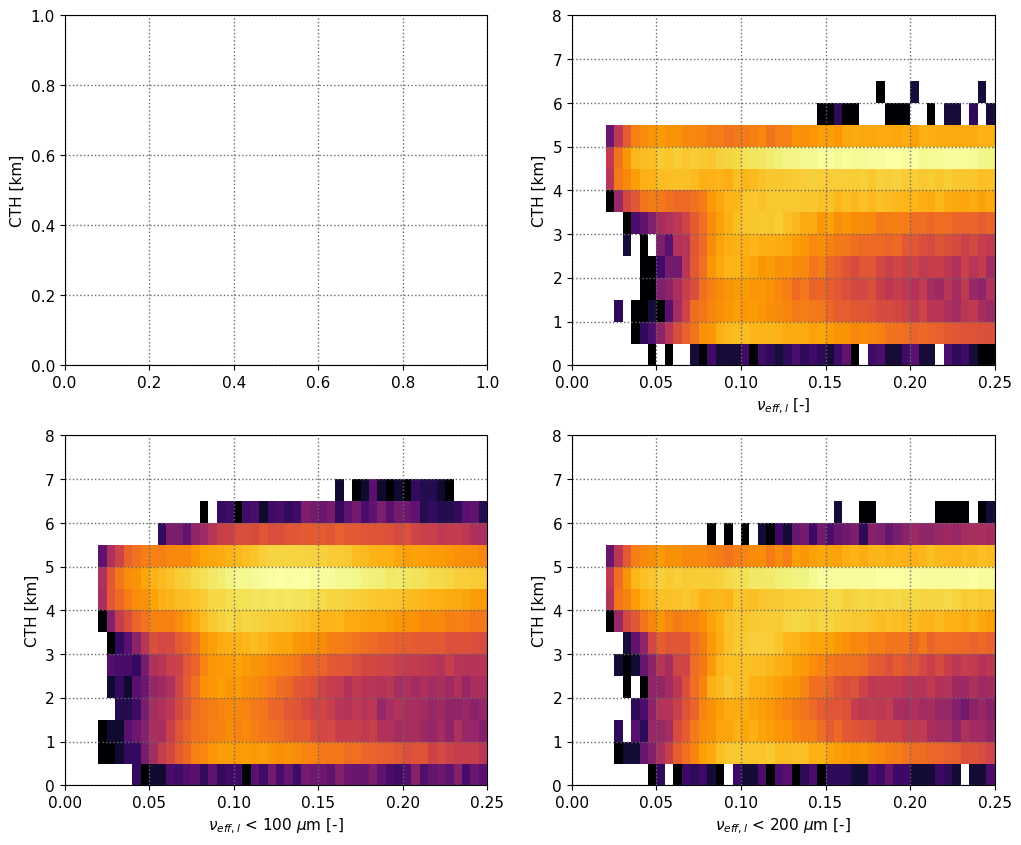

In [14]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axlist =[ax1,ax2,ax3,ax4]
Fontsize=11
for ax in axlist:
    ax.grid(which='both',ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylabel('CTH [km]',fontsize=Fontsize)

cth_bins = np.arange(0,8.5,0.5)

veff_bins = np.arange(0,0.255,0.005)
#ax1.hist2d(dum_veff_c_int,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
#ax1.set_xlabel('$\\nu_{eff,c}$ [-]',fontsize=Fontsize)

veff_bins = np.arange(0,0.255,0.005)
ax2.hist2d(dum_veff_l,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
ax2.set_xlabel('$\\nu_{eff,l}$ [-]',fontsize=Fontsize)

veff_bins = np.arange(0,0.255,0.005)
ax3.hist2d(dum_veff_l_lt_100um,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
ax3.set_xlabel('$\\nu_{eff,l}$ < 100 $\\mu$m [-]',fontsize=Fontsize)

veff_bins = np.arange(0,0.255,0.005)
ax4.hist2d(dum_veff_l_lt_200um,dum_cth,bins=[veff_bins,cth_bins],cmap='inferno',norm=matplotlib.colors.LogNorm())
ax4.set_xlabel('$\\nu_{eff,l}$ < 200 $\\mu$m [-]',fontsize=Fontsize)

plt.show()
plt.close()

# Option to read in dictionary

In [ ]:
#sim_name = 'cntl_sb_1sec'
sim_name = 'bin_turb_5x'

load_path = '/discover/nobackup/mwstanfo/dharma_post/'
file_name = load_path+sim_name+'_2D_dict_v2_9-12hrs.p'
all_dict_ct = pickle.load(open(file_name,'rb'))

In [ ]:
#=========================================
# Create a filtered dictionary for only
# points w/ CTH > 0.
#=========================================

all_dict_ct_filter = all_dict_ct.copy()
dumid = np.where((all_dict_ct_filter['cth'] > 0.) & (all_dict_ct_filter['ct_qnl_lt_200um'] > 0.) )
all_dict_ct_filter['cth'] = all_dict_ct_filter['cth'][dumid]
all_dict_ct_filter['ctt'] = all_dict_ct_filter['ctt'][dumid]
all_dict_ct_filter['ct_ql'] = all_dict_ct_filter['ct_ql'][dumid]
all_dict_ct_filter['ct_qnl'] = all_dict_ct_filter['ct_qnl'][dumid]
all_dict_ct_filter['ct_qnl_lt_100um'] = all_dict_ct_filter['ct_qnl_lt_100um'][dumid]
all_dict_ct_filter['ct_qnl_lt_200um'] = all_dict_ct_filter['ct_qnl_lt_200um'][dumid]
all_dict_ct_filter['ct_reff_l'] = all_dict_ct_filter['ct_reff_l'][dumid]
all_dict_ct_filter['ct_reff_l_lt_100um'] = all_dict_ct_filter['ct_reff_l_lt_100um'][dumid]
all_dict_ct_filter['ct_reff_l_lt_200um'] = all_dict_ct_filter['ct_reff_l_lt_200um'][dumid]

In [ ]:
tmp_keys = ['cth','ctt','ct_qnl','ct_reff_l','ct_reff_l_lt_100um','ct_reff_l_lt_200um','ct_qnl_lt_100um',\
           'ct_qnl_lt_200um']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

ct_perc_dict = {}
for tmp_key in tmp_keys:
    ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        ct_perc_dict[tmp_key][tmp_key2] = []

cth = all_dict_ct_filter['cth']*1.e-3



height_bins = np.arange(0,8000,1000)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

samp_size_vert = []

for kk in range(len(height_bins)-1):
    dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(cth)
    samp_size_vert.append(np.size(dumid))
    for tmp_key in tmp_keys:
        if dumfrac < 0.001:
            for tmp_key2 in tmp_keys2:
                if tmp_key != 'ctt':
                    ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                else:
                    if tmp_key2 == 'mean':
                        ct_perc_dict[tmp_key][tmp_key2].append(np.mean(all_dict_ct_filter[tmp_key][dumid]))
                    else:
                        ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                    
            continue
        else:
            ct_perc_dict[tmp_key]['mean'].append(np.mean(all_dict_ct_filter[tmp_key][dumid]))
            ct_perc_dict[tmp_key]['25'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],25))
            ct_perc_dict[tmp_key]['50'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],50))
            ct_perc_dict[tmp_key]['75'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],75))
            ct_perc_dict[tmp_key]['90'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],90))
            ct_perc_dict[tmp_key]['10'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],10))
            ct_perc_dict[tmp_key]['95'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],95))
            ct_perc_dict[tmp_key]['5'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        ct_perc_dict[tmp_key][tmp_key2] = np.array(ct_perc_dict[tmp_key][tmp_key2])


ctt_mean = ct_perc_dict['ctt']['mean']

# Linearly interpolate ctt_mean to height_bins
ctt_mean_interp = np.interp(height_bins,height_midbins,ctt_mean)
qn_mean_interp = np.interp(height_bins,height_midbins,ct_perc_dict['ct_qnl']['mean'])
reff_l_mean_interp = np.interp(height_bins,height_midbins,ct_perc_dict['ct_reff_l_lt_100um']['mean'])

# Pull in RSP

In [ ]:
# RSP files
path = '/discover/nobackup/mwstanfo/camp2ex_data/rsp/20190925/v2/'
base_time = datetime.datetime(2019,9,25)

files = sorted(glob.glob(path+'*.h5'))
num_files = len(files)
print(num_files)

infile = h5py.File(files[0],"r")
keys_list = list(infile.keys())
data = infile['Data']

time_arr = []
cth_arr = []
ctt_arr = []
Reff_arr = []
ve_arr = []
tau_arr = []
phase_arr = []
nd_arr = []
lwp_arr = []
cloud_test_arr = []


for tt in range(num_files):
    
    file_name = files[tt]
    file_time = file_name.split('/')[-1]
    file_time = file_time.split('.')[0]
    file_time = file_time.split('_')[-2]
    

    infile = h5py.File(file_name,"r")
    keys_list = list(infile.keys())
    data = infile['Data']
    geom = infile['Geometry']
    time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
    # Convert to datetimes
    time = np.array([base_time + datetime.timedelta(seconds=time_secs[dd]) for dd in range(len(time_secs))])
    #alt = np.array(geom['Collocated_Altitude'])
    cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
    cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
    cloud_top_temp = np.array(data['Cloud_Top_Temperature'])
    #print(np.shape(cloud_top_temp))
    cloud_liquid_index = np.array(data['Cloud_Liquid_Index'])[:,0]
    #print(np.shape(cloud_liquid_index))
    #print(aaaa)
    cloud_bow_optical_thickness = np.array(data['Cloud_Bow_Optical_Thickness'])
    cloud_bow_droplet_effective_radius = np.array(data['Cloud_Bow_Droplet_Effective_Radius'])
    cloud_bow_droplet_effective_variance = np.array(data['Cloud_Bow_Droplet_Effective_Variance'])
    cloud_bow_droplet_number_concentration_adiabatic = np.array(data['Cloud_Bow_Droplet_Number_Concentration_Adiabatic'])
    cloud_bow_liquid_water_path = np.array(data['Cloud_Bow_Liquid_Water_Path'])
    
    time_arr.append(time)
    cth_arr.append(cloud_top_alt)
    Reff_arr.append(cloud_bow_droplet_effective_radius)
    ve_arr.append(cloud_bow_droplet_effective_variance)
    tau_arr.append(cloud_bow_optical_thickness)
    phase_arr.append(cloud_liquid_index)
    cloud_test_arr.append(cloud_test_passed)
    nd_arr.append(cloud_bow_droplet_number_concentration_adiabatic)
    lwp_arr.append(cloud_bow_liquid_water_path)
    ctt_arr.append(cloud_top_temp)
    
time_arr = np.array(time_arr)
cth_arr = np.array(cth_arr)
ctt_arr = np.array(ctt_arr)
Reff_arr = np.array(Reff_arr)
ve_arr = np.array(ve_arr)
tau_arr = np.array(tau_arr)
phase_arr = np.array(phase_arr)
cloud_test_arr = np.array(cloud_test_arr)
nd_arr = np.array(nd_arr)
lwp_arr = np.array(lwp_arr)

time_arr = np.concatenate(time_arr,axis=0)
cth_arr = np.concatenate(cth_arr,axis=0)
ctt_arr = np.concatenate(ctt_arr,axis=0)
tau_arr = np.concatenate(tau_arr,axis=0)
Reff_arr = np.concatenate(Reff_arr,axis=0)
ve_arr = np.concatenate(ve_arr,axis=0)
phase_arr = np.concatenate(phase_arr,axis=0)
cloud_test_arr = np.concatenate(cloud_test_arr,axis=0)
nd_arr = np.concatenate(nd_arr,axis=0)
lwp_arr = np.concatenate(lwp_arr,axis=0)



var_dict = {'time':time_arr,\
            'cth':cth_arr,\
            'ctt':ctt_arr,\
            'Reff':Reff_arr,\
            'v_e':ve_arr,\
            'tau':tau_arr,\
            'phase':phase_arr,\
            'nd':nd_arr,\
            'lwp':lwp_arr,\
            'cloud_test':cloud_test_arr}

if True:
    dumid = np.where((var_dict['nd'] > -999.) & (var_dict['cth'] > 0.))# & (var_dict['phase'] <= 0.3) )[0]
    for key,val in var_dict.items():
        var_dict[key] = val[dumid]

        
        
        
tmp_keys = ['cth','Reff','v_e','tau','nd','lwp','ctt']
tmp_keys2 = ['mean','25','50','75','10','90','5','95']

rsp_ct_perc_dict = {}
for tmp_key in tmp_keys:
    rsp_ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = []

cth = var_dict['cth']*1.e-3
height_bins = np.arange(0,8000,1000)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

samp_size_vert = []

cth_filter_arr = []
nd_filter_arr = []
Reff_filter_arr = []

rsp_samp_size = 0
for kk in range(len(height_bins)-1):
    dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(cth)
    samp_size_vert.append(np.size(dumid))
    if np.size(dumid) > 10.:
        rsp_samp_size = rsp_samp_size + np.size(dumid)
    for tmp_key in tmp_keys:
        #print(tmp_key)
        if dumfrac < 0.001:
            for tmp_key2 in tmp_keys2:
                if tmp_key != 'ctt':
                    rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                else:
                    if tmp_key2 == 'mean':
                        rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.mean(var_dict[tmp_key][dumid]))
                    else:
                        rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                    
            continue
        else:
            rsp_ct_perc_dict[tmp_key]['mean'].append(np.mean(var_dict[tmp_key][dumid]))
            rsp_ct_perc_dict[tmp_key]['25'].append(np.percentile(var_dict[tmp_key][dumid],25))
            rsp_ct_perc_dict[tmp_key]['50'].append(np.percentile(var_dict[tmp_key][dumid],50))
            rsp_ct_perc_dict[tmp_key]['75'].append(np.percentile(var_dict[tmp_key][dumid],75))
            rsp_ct_perc_dict[tmp_key]['90'].append(np.percentile(var_dict[tmp_key][dumid],90))
            rsp_ct_perc_dict[tmp_key]['10'].append(np.percentile(var_dict[tmp_key][dumid],10))
            rsp_ct_perc_dict[tmp_key]['95'].append(np.percentile(var_dict[tmp_key][dumid],95))
            rsp_ct_perc_dict[tmp_key]['5'].append(np.percentile(var_dict[tmp_key][dumid],5))
            if tmp_key == 'nd':
                nd_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'Reff':
                Reff_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'cth':
                cth_filter_arr.append(var_dict[tmp_key][dumid])

for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = np.array(rsp_ct_perc_dict[tmp_key][tmp_key2])


rsp_ctt_mean = rsp_ct_perc_dict['ctt']['mean']-273.15


# Linearly interpolate ctt_mean to height_bins

rsp_ctt_mean_interp = np.interp(height_bins,height_midbins,rsp_ctt_mean)
rsp_qn_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['nd']['mean'])
rsp_reff_l_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['Reff']['mean'])

nd_filter_arr = np.concatenate(nd_filter_arr)
Reff_filter_arr = np.concatenate(Reff_filter_arr)
cth_filter_arr = np.concatenate(cth_filter_arr)

In [ ]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axlist = [ax1,ax2]
Fontsize=14
for ax in axlist:
    ax.grid()
    ax.set_xlabel('RSP Cloud-top $N_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
    ax.set_ylabel('Probability Density',fontsize=Fontsize)
    
nd_bins = np.arange(0,2550,50)
ax1.hist(nd_filter_arr,bins=nd_bins,histtype='step',color='navy',density=True,lw=2)
ax1.set_xlim(0,2100)
ax1.set_ylim()

nd_bins = 10.**np.arange(0,4.6,0.1)
ax2.hist(nd_filter_arr,bins=nd_bins,histtype='step',color='navy',density=True,lw=2)
ax2.set_xscale('log')
ax2.set_xlim(1,20000)


plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axlist = [ax1,ax2]
Fontsize=11
for ax in axlist:
    ax.grid()
    ax.set_ylabel('RSP CTH [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize)
ax1.set_xlabel('RSP Cloud-top $N_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
ax2.set_xlabel('RSP Cloud-top $R_{eff}$ [$\\mu$m]',fontsize=Fontsize)
    
#cth_bins = np.arange(0,5250,250)*1.e-3
cth_bins = np.arange(0,5500,500)*1.e-3

#nd_bins = np.arange(0,2050,50)
nd_bins = np.arange(0,2100,100)
plot_1 = ax1.hist2d(nd_filter_arr,cth_filter_arr*1.e-3,bins=(nd_bins,cth_bins),density=True,cmap='inferno')
#plot_1 = ax1.hexbin(nd_filter_arr,cth_filter_arr*1.e-3,cmap='inferno')
ax1.set_xlim(0,1000)
cbar_1 = fig.colorbar(plot_1[3])
#cbar_1 = fig.colorbar(plot_1)
cbar_1.ax.tick_params(labelsize=Fontsize)
cbar_1.ax.set_ylabel('Probability Density',fontsize=Fontsize)
#cbar_1.ax.set_ylabel('Count',fontsize=Fontsize)

reff_bins = np.arange(0,22,2)
plot_2 = ax2.hist2d(Reff_filter_arr,cth_filter_arr*1.e-3,bins=(reff_bins,cth_bins),density=True,cmap='inferno')
#plot_2 = ax2.hexbin(Reff_filter_arr,cth_filter_arr*1.e-3,cmap='inferno')
cbar_2 = fig.colorbar(plot_2[3])
#cbar_2 = fig.colorbar(plot_2)
cbar_2.ax.tick_params(labelsize=Fontsize)
cbar_2.ax.set_ylabel('Probability Density',fontsize=Fontsize)
#cbar_2.ax.set_ylabel('Count',fontsize=Fontsize)

plt.subplots_adjust(wspace=0.2)
plt.show()
plt.close()

In [ ]:
#------------------------------------
#------------------------------------
# Plot 2-panel
#------------------------------------
#------------------------------------


fig = plt.figure(figsize=(3.5,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
Fontsize=11
axlist = [ax1,ax2]
#ax1.grid(lw=1,c='dimgrey',ls='dotted')
for ax in axlist:
    ax.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize,direction='in',which='both',length=10)
    ax.set_yticks([0,2,4,6])

    
dark_color='navy'
mid_color = 'royalblue'
light_color = 'lightsteelblue'
#=================================
# Number concentration
#=================================
var1 = 'ct_qnl_lt_200um'
#var1 = 'ct_qncloud'
qn_10 = ct_perc_dict[var1]['10']
qn_90 = ct_perc_dict[var1]['90']
qn_25 = ct_perc_dict[var1]['25']
qn_med = ct_perc_dict[var1]['50']
qn_75 = ct_perc_dict[var1]['75']
qn_mean = ct_perc_dict[var1]['mean']
var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']


for ii in range(len(height_bins)-1):
    

    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # DHARMA
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    
    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax1.set_xlim(0,1000)
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
#ax1.plot(qn_med,height_midbins-0.2,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
#ax1.plot(rsp_qn_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)

#=================================
# Effective Radius
#=================================
var2 = 'ct_reff_l_lt_200um'
#var2 = 'ct_reff_c'
reff_c_10 = ct_perc_dict[var2]['10']
reff_c_90 = ct_perc_dict[var2]['90']
reff_c_25 = ct_perc_dict[var2]['25']
reff_c_med = ct_perc_dict[var2]['50']
reff_c_75 = ct_perc_dict[var2]['75']
reff_c_mean = ct_perc_dict[var2]['mean']

var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------
    
    
    ##############
    # DHARMA
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax2.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax2.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    
    # Add whiskers
    ax2.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax2.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax2.set_xlim(0,20)
ax2.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
#ax2.plot(reff_c_med,height_midbins-0.2,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax2.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
#ax2.plot(rsp_reff_c_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax2.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)


for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    #ax.set_ylim(0)
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ax1a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 20
#ax1b.plot(ctt_mean_interp,height_bins,marker='D',alpha=0.5)
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax1a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])

# Plot CTT on second subplot
ax2a = ax2.twinx()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax2a.yaxis.labelpad = 20
ax2b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.set_xticks([])
dum_yticks = ax2.get_yticks()
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax2a.set_yticklabels(dum_yticks2)
ax2a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax2.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.set_ylim(height_bins[0],height_bins[-1])

ax1.text(-0.22,1.03,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(-0.22,1.03,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

ax1.text(1020,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax2.text(20.5,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')

custom_lines = [matplotlib.lines.Line2D([0],[0],lw=3,c='dimgrey',ls='dashdot',label='0 $^{\\circ}$C')]
ax1.legend(framealpha=False,loc='upper right')
#ax2.legend(framealpha=False,loc='upper right')

ax1.text(0.99,1.10,'DHARMA N='+str(int(len(all_dict_ct_filter['cth']))),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color,transform=ax1.transAxes,ha='right',va='bottom')
ax2.text(0.99,1.01,'RSP N='+str(int(rsp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c='k',transform=ax1.transAxes,ha='right',va='bottom')

plt.subplots_adjust(hspace=0.25)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_rsp_dharma_CNTL_cloud_top.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()  



In [ ]:
#==========================================
# Maps of new CTH calclations
#==========================================

cth = ct_dict['cth']
ctt = ct_dict['ctt']
ct_qnl = ct_dict['ct_qnl']
ct_qnl_lt_100um = ct_dict['ct_qnl_lt_100um']
ct_qnl_lt_200um = ct_dict['ct_qnl_lt_200um']
ct_reff_l = ct_dict['ct_reff_l']
ct_reff_l_lt_100um = ct_dict['ct_reff_l_lt_100um']
ct_reff_l_lt_200um = ct_dict['ct_reff_l_lt_200um']

fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(16,8))
axes_flat = np.ndarray.flatten(axes)
Fontsize=14

Fontsize=9
for ax in axes_flat:
    ax.grid(ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('x [km]',fontsize=Fontsize)
    ax.set_ylabel('y [km]',fontsize=Fontsize)
    
    
# CTH
var_levs = np.arange(0,5.6,0.1)
plot = axes_flat[0].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,cth*1.e-3,levels=var_levs,cmap='turbo',extend='max')
axes_flat[0].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('CTH [km]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

# optical thickness
var_levs = 10.**np.arange(-1,3.1,0.1)
plot = axes_flat[1].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=var_levs,cmap='turbo',extend='both',norm=matplotlib.colors.LogNorm())
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('Optical Thickness',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[1].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top nl < 100 um
var_levs = np.arange(0,625,25)
plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qnl_lt_100um,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('N$_{l}$ < 100$\\mu$m [cm$^{-3}$]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[2].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top reff_l
var_levs = np.arange(0,10.5,0.5)
plot = axes_flat[3].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_l,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,l}$ [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[3].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top reff_l < 100 um
var_levs = np.arange(0,10.5,0.5)
plot = axes_flat[4].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_l_lt_100um,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,l}$ < 100 $\\mu$m [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[4].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top reff_l < 100 um
var_levs = np.arange(0,10.5,0.5)
plot = axes_flat[5].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_l_lt_200um,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,l}$ < 200 $\\mu$m [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[5].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

plt.subplots_adjust(wspace=0.25)

plt.show()
plt.close()

In [ ]:
path = '/discover/nobackup/mwstanfo/camp2ex_data/rsp/20190925/v2/'
base_time = datetime.datetime(2019,9,25)

files = sorted(glob.glob(path+'*.h5'))
num_files = len(files)
print(num_files)

infile = h5py.File(files[0],"r")
keys_list = list(infile.keys())
data = infile['Data']
data_keys = list(data.keys())


In [ ]:
data_keys

# Run in Serial

In [ ]:
micro_scheme = 'SB'
start_id = 0 # 10
dharma_dict = main(files_3d[start_id],micro_scheme)
dharma_dict = get_dsd_params(dharma_dict,micro_scheme)
#dharma_dict = calc_effective_radius(dharma_dict,micro_scheme)
print('done')

In [ ]:
qcloud = dharma_dict['qcloud']
qrain = dharma_dict['qrain']
qncloud = dharma_dict['qncloud']
qnrain = dharma_dict['qnrain']
rho = dharma_dict['rho']
lam_r = dharma_dict['lam_r']
lam_c = dharma_dict['lam_c']
n0_r = dharma_dict['n0_r']
n0_c = dharma_dict['n0_c']
nx = dharma_dict['nx']
ny = dharma_dict['ny']
nz = dharma_dict['nz']
reff_c = dharma_dict['reff_c']
dz = dharma_dict['dz']
rho = dharma_dict['rho']
z = dharma_dict['z']

#========================================================
# Parameters for gamma distributions
#========================================================
qsmall = 1.e-14

# Cloud water
disp = 0.3 # from input parameter file

pgamc = 1./disp**2. - 1.
pgamc = max(  2., pgamc )
pgamc = min( 30., pgamc )

# Rain
gamr_fix = 3.
pgamr = gamr_fix
#========================================================


#==============================================
# Combined effective radius
#==============================================
qliq = qcloud+qrain
#liq_id = np.where(qliq > 0.0001)#qsmall)
liq_id = np.where(qliq > qsmall)

#rad = dharma_dict['rbound']*1.e-6 # meters
#num_r = len(rad)   
#rad_midbins = dharma_dict['radius']*1.e-6 # meters    

rad = np.array([1.0908325e+00, 1.2889994e+00, 1.5231664e+00, 1.7998737e+00,
   2.1268492e+00, 2.5132246e+00, 2.9697914e+00, 3.5093009e+00,
   4.1468210e+00, 4.9001560e+00, 5.7903466e+00, 6.8422546e+00,
   8.0852575e+00, 9.5540724e+00, 1.1289721e+01, 1.3340674e+01,
   1.5764219e+01, 1.8628036e+01, 2.2012114e+01, 2.6010962e+01,
   3.0736261e+01, 3.6319988e+01, 4.2918083e+01, 5.0714832e+01,
   5.9927982e+01, 7.0814842e+01, 8.3679474e+01, 9.8881165e+01,
   1.1684450e+02, 1.3807112e+02, 1.6315393e+02, 1.9279343e+02,
   2.2781737e+02, 2.6920398e+02, 3.1810913e+02, 3.7589862e+02,
   4.4418655e+02, 5.2488007e+02, 6.2023279e+02, 7.3290778e+02,
   8.6605206e+02, 1.0233841e+03, 1.2092980e+03, 1.4289858e+03,
   1.6885837e+03, 1.9953414e+03, 2.3578269e+03, 2.7861631e+03,
   3.2923137e+03, 3.8904143e+03])*1.e-6 # meters

rbound = np.array([9.9999958e-01, 1.1816654e+00, 1.3963336e+00, 1.6499995e+00,
1.9497479e+00, 2.3039503e+00, 2.7224991e+00, 3.2170839e+00,
3.8015180e+00, 4.4921236e+00, 5.3081889e+00, 6.2725048e+00,
7.4120040e+00, 8.7585115e+00, 1.0349633e+01, 1.2229807e+01,
1.4451543e+01, 1.7076893e+01, 2.0179180e+01, 2.3845047e+01,
2.8176876e+01, 3.3295647e+01, 3.9344326e+01, 4.6491840e+01,
5.4937820e+01, 6.4918144e+01, 7.6711540e+01, 9.0647408e+01,
1.0711493e+02, 1.2657405e+02, 1.4956821e+02, 1.7673964e+02,
2.0884718e+02, 2.4678755e+02, 2.9162039e+02, 3.4459784e+02,
4.0719946e+02, 4.8117365e+02, 5.6858643e+02, 6.7187915e+02,
7.9393652e+02, 9.3816766e+02, 1.1086006e+03, 1.3099954e+03,
1.5479766e+03, 1.8291908e+03, 2.1614922e+03, 2.5541611e+03,
3.0181650e+03, 3.5664624e+03, 4.2143662e+03])*1.e-6 # meters
dr = np.diff(rbound)

num_r = len(rad)    
rad_midbins = rad.copy()    

#rad = 10.**(np.arange(0,5.1,0.1))*1.e-6 # meters
#num_r = len(rad)
#rad_midbins = rad.copy()

id_lt_100um = np.squeeze(np.where(rad_midbins*1.e6 <= 50.))
id_lt_200um = np.squeeze(np.where(rad_midbins*1.e6 <= 100.))
id_lt_3mm = np.squeeze(np.where(rad_midbins*1.e6 <= 1500.))   

reff_l = np.zeros((nx,ny,nz))-999.
reff_l_lt_100um = np.zeros((nx,ny,nz))-999.
qnl_lt_100um = np.zeros((nx,ny,nz))
qnl_lt_200um = np.zeros((nx,ny,nz))
reff_l_lt_200um = np.zeros((nx,ny,nz))-999.
reff_l_lt_3mm = np.zeros((nx,ny,nz))-999.
reff_c_int = np.zeros((nx,ny,nz))-999.
reff_r_int = np.zeros((nx,ny,nz))-999.
r3_l = np.zeros((nx,ny,nz))-999.
r2_l = np.zeros((nx,ny,nz))-999.
r3_l_lt_100um = np.zeros((nx,ny,nz))-999.
r2_l_lt_100um = np.zeros((nx,ny,nz))-999.
r3_l_lt_200um = np.zeros((nx,ny,nz))-999.
r2_l_lt_200um = np.zeros((nx,ny,nz))-999.
opd = np.zeros((nx,ny,nz))
opd_cloud = np.zeros((nx,ny,nz))
opd_rain = np.zeros((nx,ny,nz))
ext = np.zeros((nx,ny,nz))
ext_cloud = np.zeros((nx,ny,nz))
ext_rain = np.zeros((nx,ny,nz))

len_liq_id = len(liq_id[0])

for ii in range(len_liq_id):

    i_id = liq_id[0][ii]
    j_id = liq_id[1][ii]
    k_id = liq_id[2][ii]


    if lam_c[i_id,j_id,k_id] > 0.:
        nrc = n0_c[i_id,j_id,k_id]*(rad_midbins**pgamc)*np.exp(-lam_c[i_id,j_id,k_id]*rad_midbins) #/m^4

        reff_c_num = np.trapezoid((nrc*rad_midbins**3.),rad_midbins)#,dx=1.e-6)
        reff_c_den = np.trapezoid((nrc*rad_midbins**2.),rad_midbins)#,dx=1.e-6)
        reff_c_int[i_id,j_id,k_id] = (reff_c_num/reff_c_den)*1.e6/2.   

        reff_c_num_lt_100um = np.trapezoid((nrc[id_lt_100um]*rad_midbins[id_lt_100um]**3.),rad_midbins[id_lt_100um])#,dx=1.e-6)
        reff_c_num_lt_200um = np.trapezoid((nrc[id_lt_200um]*rad_midbins[id_lt_200um]**3.),rad_midbins[id_lt_200um])#,dx=1.e-6)
        reff_c_num_lt_3mm = np.trapezoid((nrc[id_lt_3mm]*rad_midbins[id_lt_3mm]**3.),rad_midbins[id_lt_3mm])#,dx=1.e-6)
        reff_c_den_lt_100um = np.trapezoid((nrc[id_lt_100um]*rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])#,dx=1.e-6)
        reff_c_den_lt_200um = np.trapezoid((nrc[id_lt_200um]*rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])#,dx=1.e-6)
        reff_c_den_lt_3mm = np.trapezoid((nrc[id_lt_3mm]*rad_midbins[id_lt_3mm]**2.),rad_midbins[id_lt_3mm])#,dx=1.e-6)

        reff_c_lt_100um = reff_c_num_lt_100um/reff_c_den_lt_100um*1.e6/2.
        reff_c_lt_200um = reff_c_num_lt_200um/reff_c_den_lt_200um*1.e6/2.
        reff_c_lt_3mm = reff_c_num_lt_3mm/reff_c_den_lt_3mm*1.e6/2.

        opd_cloud[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(nrc)*dz[k_id]*(rad_midbins**2.),rad_midbins)
        ext_cloud[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(nrc)*(rad_midbins**2.),rad_midbins)


    if lam_r[i_id,j_id,k_id] > 0.:
        if micro_scheme == 'SB':
            nrr = n0_r[i_id,j_id,k_id]*(rad_midbins**pgamr)*np.exp(-lam_r[i_id,j_id,k_id]*rad_midbins) #/m^4
        elif micro_scheme == 'KK':
            nrr = n0_r[i_id,j_id,k_id]*np.exp(-lam_r[i_id,j_id,k_id]*rad_midbins) #/m^4          

        reff_r_num = np.trapezoid((nrr*rad_midbins**3.),rad_midbins)#,dx=1.e-6)
        reff_r_den = np.trapezoid((nrr*rad_midbins**2.),rad_midbins)#,dx=1.e-6) 
        reff_r_int[i_id,j_id,k_id] = (reff_r_num/reff_r_den)*1.e6/2.             

        reff_r_num_lt_100um = np.trapezoid((nrr[id_lt_100um]*rad_midbins[id_lt_100um]**3.),rad_midbins[id_lt_100um])#,dx=1.e-6)
        reff_r_num_lt_200um = np.trapezoid((nrr[id_lt_200um]*rad_midbins[id_lt_200um]**3.),rad_midbins[id_lt_200um])#,dx=1.e-6)
        reff_r_num_lt_3mm = np.trapezoid((nrr[id_lt_3mm]*rad_midbins[id_lt_3mm]**3.),rad_midbins[id_lt_3mm])#,dx=1.e-6)
        reff_r_den_lt_100um = np.trapezoid((nrr[id_lt_100um]*rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])#,dx=1.e-6)
        reff_r_den_lt_200um = np.trapezoid((nrr[id_lt_200um]*rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])#,dx=1.e-6)
        reff_r_den_lt_3mm = np.trapezoid((nrr[id_lt_3mm]*rad_midbins[id_lt_3mm]**2.),rad_midbins[id_lt_3mm])#,dx=1.e-6)  

        reff_r_lt_100um = reff_r_num_lt_100um/reff_r_den_lt_100um*1.e6/2.
        reff_r_lt_200um = reff_r_num_lt_200um/reff_r_den_lt_200um*1.e6/2.
        reff_r_lt_3mm = reff_r_num_lt_3mm/reff_r_den_lt_3mm*1.e6/2. 

        opd_rain[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(nrr)*dz[k_id]*(rad_midbins**2.),rad_midbins)
        ext_rain[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(nrr)*(rad_midbins**2.),rad_midbins)


    if (lam_r[i_id,j_id,k_id] > 0.) and (lam_c[i_id,j_id,k_id] > 0.): 
        reff_rc = (reff_c_num + reff_r_num)/(reff_c_den + reff_r_den)*1.e6/2.
        reff_l[i_id,j_id,k_id] = reff_rc
        nr = nrc + nrr
        tmp_qnl_lt_100um = np.trapezoid(nr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        tmp_qnl_lt_200um = np.trapezoid(nr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        qnl_lt_100um[i_id,j_id,k_id] = tmp_qnl_lt_100um
        qnl_lt_200um[i_id,j_id,k_id] = tmp_qnl_lt_200um
        #print(tmp_qnl_lt_100um)
        #print(tmp_qnl_lt_200um)
        #print(qncloud[i_id,j_id,k_id]*rho[k_id]*1.e-6)
        #print(qnrain[i_id,j_id,k_id]*rho[k_id]*1.e-6)
        #print(aaaaa)

        r3_l[i_id,j_id,k_id] = reff_r_num + reff_c_num
        r2_l[i_id,j_id,k_id] = reff_r_den + reff_c_den

    elif (lam_r[i_id,j_id,k_id] < 0.) and (lam_c[i_id,j_id,k_id] > 0.): 
        reff_l[i_id,j_id,k_id] = reff_c_int[i_id,j_id,k_id]
        nr = nrc
        r3_l[i_id,j_id,k_id] = reff_c_num
        r2_l[i_id,j_id,k_id] = reff_c_den
        tmp_qnl_lt_100um = np.trapezoid(nr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        tmp_qnl_lt_200um = np.trapezoid(nr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        qnl_lt_100um[i_id,j_id,k_id] = tmp_qnl_lt_100um
        qnl_lt_200um[i_id,j_id,k_id] = tmp_qnl_lt_200um
        #print(tmp_qnl_lt_100um)
        #print(tmp_qnl_lt_200um)
        #print(qncloud[i_id,j_id,k_id]*rho[k_id]*1.e-6)
        #print(qnrain[i_id,j_id,k_id]*rho[k_id]*1.e-6)
        #print(aaaaa)
    elif (lam_r[i_id,j_id,k_id] > 0.) and (lam_c[i_id,j_id,k_id] < 0.): 
        reff_l[i_id,j_id,k_id] = reff_r_int[i_id,j_id,k_id]
        nr = nrr
        r3_l[i_id,j_id,k_id] = reff_r_num
        r2_l[i_id,j_id,k_id] = reff_r_den
        tmp_qnl_lt_100um = np.trapezoid(nr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        tmp_qnl_lt_200um = np.trapezoid(nr[id_lt_100um],rad_midbins[id_lt_100um])*1.e-6
        qnl_lt_100um[i_id,j_id,k_id] = tmp_qnl_lt_100um
        qnl_lt_200um[i_id,j_id,k_id] = tmp_qnl_lt_200um
        #print(tmp_qnl_lt_100um)
        #print(tmp_qnl_lt_200um)
        #print(qncloud[i_id,j_id,k_id]*rho[k_id]*1.e-6)
        #print(qnrain[i_id,j_id,k_id]*rho[k_id]*1.e-6)
        #print(aaaaa)

    #opd[i_id,j_id,k_id] = np.sum(2.*np.pi*(nr*dr)*dz[k_id]*(rad_midbins**2.))
    opd[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(nr)*dz[k_id]*(rad_midbins**2.),rad_midbins)
    ext[i_id,j_id,k_id] = np.trapezoid(2.*np.pi*(nr)*(rad_midbins**2.),rad_midbins)


    reff_rc_num_lt_100um = np.trapezoid((nr[id_lt_100um]*rad_midbins[id_lt_100um]**3.),rad_midbins[id_lt_100um])#,dx=1.e-6)
    reff_rc_num_lt_200um = np.trapezoid((nr[id_lt_200um]*rad_midbins[id_lt_200um]**3.),rad_midbins[id_lt_200um])#,dx=1.e-6)
    reff_rc_num_lt_3mm = np.trapezoid((nr[id_lt_3mm]*rad_midbins[id_lt_3mm]**3.),rad_midbins[id_lt_3mm])#,dx=1.e-6)
    reff_rc_den_lt_100um = np.trapezoid((nr[id_lt_100um]*rad_midbins[id_lt_100um]**2.),rad_midbins[id_lt_100um])#,dx=1.e-6)
    reff_rc_den_lt_200um = np.trapezoid((nr[id_lt_200um]*rad_midbins[id_lt_200um]**2.),rad_midbins[id_lt_200um])#,dx=1.e-6)
    reff_rc_den_lt_3mm = np.trapezoid((nr[id_lt_3mm]*rad_midbins[id_lt_3mm]**2.),rad_midbins[id_lt_3mm])#,dx=1.e-6)      

    reff_rc_lt_100um = reff_rc_num_lt_100um/reff_rc_den_lt_100um*1.e6/2.
    reff_rc_lt_200um = reff_rc_num_lt_200um/reff_rc_den_lt_200um*1.e6/2.
    reff_rc_lt_3mm = reff_rc_num_lt_3mm/reff_rc_den_lt_3mm*1.e6/2.

    reff_l_lt_100um[i_id,j_id,k_id] = reff_rc_lt_100um
    reff_l_lt_200um[i_id,j_id,k_id] = reff_rc_lt_200um
    reff_l_lt_3mm[i_id,j_id,k_id] = reff_rc_lt_3mm

    r3_l_lt_100um[i_id,j_id,k_id] = reff_rc_num_lt_100um
    r2_l_lt_100um[i_id,j_id,k_id] = reff_rc_den_lt_100um

    r3_l_lt_200um[i_id,j_id,k_id] = reff_rc_num_lt_200um
    r2_l_lt_200um[i_id,j_id,k_id] = reff_rc_den_lt_200um

if True:
    dharma_dict['reff_l'] = reff_l
    dharma_dict['r3_l'] = r3_l
    dharma_dict['r2_l'] = r2_l
    dharma_dict['r3_l_lt_100um'] = r3_l_lt_100um
    dharma_dict['r2_l_lt_100um'] = r2_l_lt_100um
    dharma_dict['r3_l_lt_200um'] = r3_l_lt_200um
    dharma_dict['r2_l_lt_200um'] = r2_l_lt_200um
    dharma_dict['reff_c_int'] = reff_c_int
    dharma_dict['reff_r_int'] = reff_r_int
    dharma_dict['reff_l_lt_100um'] = reff_l_lt_100um
    dharma_dict['reff_l_lt_200um'] = reff_l_lt_200um
    dharma_dict['reff_l_lt_3mm'] = reff_l_lt_3mm
    dharma_dict['qnl_lt_100um'] = qnl_lt_100um
    dharma_dict['qnl_lt_200um'] = qnl_lt_200um
    dharma_dict['opd'] = opd
    dharma_dict['opd_cloud'] = opd_cloud
    dharma_dict['opd_rain'] = opd_rain
    dharma_dict['ext'] = ext
    dharma_dict['ext_cloud'] = ext_cloud
    dharma_dict['ext_rain'] = ext_rain
    dharma_dict['op_thick'] = np.sum(opd,axis=2)
print('done')

In [ ]:
print('done')

In [ ]:
#opd = dharma_dict['opd']
opd = dharma_dict['opd_cloud']
opd_cloud = dharma_dict['opd_cloud']
reff_c = dharma_dict['reff_c']
reff_l = dharma_dict['reff_l']
reff_l_lt_100um = dharma_dict['reff_l_lt_100um']
reff_l_lt_200um = dharma_dict['reff_l_lt_200um']
r3_l = dharma_dict['r3_l']
r2_l = dharma_dict['r2_l']
r3_l_lt_100um = dharma_dict['r3_l_lt_100um']
r2_l_lt_100um = dharma_dict['r2_l_lt_100um']
r3_l_lt_200um = dharma_dict['r3_l_lt_200um']
r2_l_lt_200um = dharma_dict['r2_l_lt_200um']

qncloud = dharma_dict['qncloud']
qnl_lt_100um = dharma_dict['qnl_lt_100um']
qnl_lt_200um = dharma_dict['qnl_lt_200um']
qnrain = dharma_dict['qnrain']
rho = dharma_dict['rho']
z = dharma_dict['z']
qcloud = dharma_dict['qcloud']
qrain = dharma_dict['qrain']
ql = qcloud + qrain
qnl = qncloud + qnrain
temp = dharma_dict['temp']
nx = dharma_dict['nx']
ny = dharma_dict['ny']
#ext = dharma_dict['ext']
ext = dharma_dict['ext_cloud']
ext_cloud = dharma_dict['ext_cloud']
dz = dharma_dict['dz']



dumid = np.where(z <= 10000.)
z = z[dumid]
qcloud = qcloud[:,:,dumid]
qrain = qrain[:,:,dumid]
ql = ql[:,:,dumid]
qncloud = qncloud[:,:,dumid]
qnrain = qnrain[:,:,dumid]
qnl = qnl[:,:,dumid]
qnl_lt_100um = qnl_lt_100um[:,:,dumid]
qnl_lt_200um = qnl_lt_200um[:,:,dumid]
temp = temp[:,:,dumid]
rho = rho[dumid]
reff_c = reff_c[:,:,dumid]
reff_l = reff_l[:,:,dumid]
reff_l_lt_100um = reff_l_lt_100um[:,:,dumid]
reff_l_lt_200um = reff_l_lt_200um[:,:,dumid]
opd = opd[:,:,dumid]
ext = ext[:,:,dumid]
r3_l = r3_l[:,:,dumid]
r2_l = r2_l[:,:,dumid]
r3_l_lt_100um = r3_l_lt_100um[:,:,dumid]
r2_l_lt_100um = r2_l_lt_100um[:,:,dumid]
r3_l_lt_200um = r3_l_lt_200um[:,:,dumid]
r2_l_lt_200um = r2_l_lt_200um[:,:,dumid]

dz = dz[dumid]
nz = len(z)

cth = np.zeros((nx,ny))-999.
ctt = np.zeros((nx,ny))-999.
ct_qcloud = np.zeros((nx,ny))-999.
ct_qrain = np.zeros((nx,ny))-999.
ct_ql = np.zeros((nx,ny))-999.
ct_qncloud = np.zeros((nx,ny))-999.
ct_qnrain = np.zeros((nx,ny))-999.
ct_qnl = np.zeros((nx,ny))-999.
ct_qnl_lt_100um = np.zeros((nx,ny))-999.
ct_qnl_lt_200um = np.zeros((nx,ny))-999.
ct_reff_c = np.zeros((nx,ny))-999.
ct_reff_l = np.zeros((nx,ny))-999.
ct_reff_l_lt_100um = np.zeros((nx,ny))-999.
ct_reff_l_lt_200um = np.zeros((nx,ny))-999.
ct_rho = np.zeros((nx,ny))-999.
ct_opd = np.zeros((nx,ny))-999.
ct_ext = np.zeros((nx,ny))-999.

min_thresh = 1.e-9 # kg/kg (equivalent to 1.e-6 g/kg)
opt_thresh = 1

for ii in range(nx):
    for jj in range(ny):
        single_prof_ql = np.squeeze(np.flip(ql[ii,jj,:]))
        single_prof_qcloud = np.squeeze(np.flip(qcloud[ii,jj,:]))
        single_prof_qnl = np.squeeze(np.flip(qnl[ii,jj,:]))
        single_prof_qnl_lt_100um = np.squeeze(np.flip(qnl_lt_100um[ii,jj,:]))
        single_prof_qnl_lt_200um = np.squeeze(np.flip(qnl_lt_200um[ii,jj,:]))
        #if (np.max(single_prof_qnl) > 1.) and (np.max(single_prof_qnl_lt_100um) < 1.):
        #if (np.max(single_prof_qnl) > 1.) and (np.max(single_prof_qnl_lt_100um) == 0.):
        #if (np.max(single_prof_qnl) > 1.) and (np.max(single_prof_qnl_lt_100um) < 1.):
        #    print(aaaaa)
        
        #if (np.max(single_prof_ql) < min_thresh) or (np.max(single_prof_qnl_lt_100um) == 0.):
        #if (np.max(single_prof_ql) < min_thresh) or (np.max(single_prof_qnl_lt_100um) < 1.):
        if (np.max(single_prof_qnl_lt_100um) < 1.):
        #if np.max(single_prof_ql) < min_thresh:
        #if np.max(single_prof_qcloud) < min_thresh:
            continue
        else:
            pass

        single_prof_z = np.squeeze(np.flip(z))
        single_prof_rho = np.squeeze(np.flip(rho))
        single_prof_qrain = np.squeeze(np.flip(qrain[ii,jj,:]))
        single_prof_qncloud = np.squeeze(np.flip(qncloud[ii,jj,:]))
        single_prof_qnrain = np.squeeze(np.flip(qnrain[ii,jj,:]))
        single_prof_temp = np.squeeze(np.flip(temp[ii,jj,:]))
        single_prof_reff_c = np.squeeze(np.flip(reff_c[ii,jj,:]))
        single_prof_reff_l = np.squeeze(np.flip(reff_l[ii,jj,:]))
        single_prof_reff_l_lt_100um = np.squeeze(np.flip(reff_l_lt_100um[ii,jj,:]))
        single_prof_reff_l_lt_200um = np.squeeze(np.flip(reff_l_lt_200um[ii,jj,:]))
        single_prof_opd = np.squeeze(np.flip(opd[ii,jj,:]))
        single_prof_ext = np.squeeze(np.flip(ext[ii,jj,:]))
        single_prof_dz = np.squeeze(np.flip(dz))
        single_prof_r3_l = np.squeeze(np.flip(r3_l[ii,jj,:]))
        single_prof_r2_l = np.squeeze(np.flip(r2_l[ii,jj,:]))
        single_prof_r3_l_lt_100um = np.squeeze(np.flip(r3_l_lt_100um[ii,jj,:]))
        single_prof_r2_l_lt_100um = np.squeeze(np.flip(r2_l_lt_100um[ii,jj,:]))
        single_prof_r3_l_lt_200um = np.squeeze(np.flip(r3_l_lt_200um[ii,jj,:]))
        single_prof_r2_l_lt_200um = np.squeeze(np.flip(r2_l_lt_200um[ii,jj,:]))
        
        tau = 0
        qnl_wgt = []
        qnl_lt_100um_wgt = []
        qnl_lt_200um_wgt = []
        tau_wgt = []
        ext_wgt = []
        z_wgt = []
        dz_wgt = []
        opd_wgt = []
        r3_l_wgt = []
        r2_l_wgt = []
        r3_l_lt_100um_wgt = []
        r2_l_lt_100um_wgt = []
        r3_l_lt_200um_wgt = []
        r2_l_lt_200um_wgt = []
        reff_l_wgt = []
        reff_c_wgt = []
        qncloud_wgt = []
        reff_l_lt_100um_wgt = []
        reff_l_lt_200um_wgt = []
        ql_wgt = []
        qrain_wgt = []
        qcloud_wgt = []
        qnrain_wgt = []
        
        for kk in range(nz):
            tau = tau + single_prof_opd[kk]
            if tau > opt_thresh:
                #print(single_prof_z[kk],single_prof_qnl[kk]*single_prof_rho[kk]*1.e-6,single_prof_ext[kk],single_prof_dz[kk],tau,single_prof_opd[kk])
                qnl_wgt.append(single_prof_qnl[kk]*single_prof_rho[kk]*1.e-6)
                qnl_lt_100um_wgt.append(single_prof_qnl_lt_100um[kk])
                qnl_lt_200um_wgt.append(single_prof_qnl_lt_200um[kk])
                qncloud_wgt.append(single_prof_qncloud[kk]*single_prof_rho[kk]*1.e-6)
                tau_wgt.append(tau)
                z_wgt.append(single_prof_z[kk])
                ql_wgt.append(single_prof_ql[kk])
                qcloud_wgt.append(single_prof_qcloud[kk])
                qrain_wgt.append(single_prof_qrain[kk])
                qnrain_wgt.append(single_prof_qnrain[kk])
                ext_wgt.append(single_prof_ext[kk])
                dz_wgt.append(single_prof_dz[kk])
                opd_wgt.append(single_prof_opd[kk])
                reff_l_wgt.append(single_prof_reff_l[kk])
                reff_c_wgt.append(single_prof_reff_c[kk])
                reff_l_lt_100um_wgt.append(single_prof_reff_l_lt_100um[kk])
                reff_l_lt_200um_wgt.append(single_prof_reff_l_lt_200um[kk])
                r3_l_wgt.append(single_prof_r3_l[kk])
                r2_l_wgt.append(single_prof_r2_l[kk])
                r3_l_lt_100um_wgt.append(single_prof_r3_l_lt_100um[kk])
                r2_l_lt_100um_wgt.append(single_prof_r2_l_lt_100um[kk])
                r3_l_lt_200um_wgt.append(single_prof_r3_l_lt_200um[kk])
                r2_l_lt_200um_wgt.append(single_prof_r2_l_lt_200um[kk])
            if tau >= opt_thresh:
                cth[ii,jj] = single_prof_z[kk]
                ctt[ii,jj] = single_prof_temp[kk]
                ct_rho[ii,jj] = single_prof_rho[kk]
                ct_qcloud[ii,jj] = single_prof_qcloud[kk]
                ct_opd[ii,jj] = tau
                ct_qrain[ii,jj] = single_prof_qrain[kk]
                ct_ql[ii,jj] = single_prof_ql[kk]
                #ct_qncloud[ii,jj] = single_prof_qncloud[kk]
                #ct_qnrain[ii,jj] = single_prof_qnrain[kk]
                #ct_qnl[ii,jj] = single_prof_qnl[kk]
                #ct_reff_c[ii,jj] = single_prof_reff_c[kk]
                #ct_reff_l[ii,jj] = single_prof_reff_l[kk]
                #ct_reff_l_lt_100um[ii,jj] = single_prof_reff_l_lt_100um[kk]
                #ct_reff_l_lt_200um[ii,jj] = single_prof_reff_l_lt_200um[kk]
                break
                
        if np.size(tau_wgt) == 0.:
            continue
                
        if np.max(tau_wgt) >= opt_thresh:
            opd_wgt = np.array(opd_wgt)
            dz_wgt = np.array(dz_wgt)
            qnl_wgt = np.array(qnl_wgt)
            qnl_lt_100um_wgt = np.array(qnl_lt_100um_wgt)
            qnl_lt_200um_wgt = np.array(qnl_lt_200um_wgt)
            qncloud_wgt = np.array(qncloud_wgt)
            qcloud_wgt = np.array(qcloud_wgt)
            ql_wgt = np.array(ql_wgt)
            qrain_wgt = np.array(qrain_wgt)
            qnrain_wgt = np.array(qnrain_wgt)
            z_wgt = np.array(z_wgt)
            tau_wgt = np.array(tau_wgt)
            reff_l_wgt = np.array(reff_l_wgt)
            reff_c_wgt = np.array(reff_c_wgt)
            reff_l_lt_100um_wgt = np.array(reff_l_lt_100um_wgt)
            reff_l_lt_200um_wgt = np.array(reff_l_lt_200um_wgt)
            r3_l_wgt = np.array(r3_l_wgt)
            r2_l_wgt = np.array(r2_l_wgt)
            r3_l_lt_100um_wgt = np.array(r3_l_lt_100um_wgt)
            r2_l_lt_100um_wgt = np.array(r2_l_lt_100um_wgt)
            r3_l_lt_200um_wgt = np.array(r3_l_lt_200um_wgt)
            r2_l_lt_200um_wgt = np.array(r2_l_lt_200um_wgt)
            
            qncloud_wgt[qncloud_wgt < 0.] = 0.
            
            qncloud_wgt_num = np.trapezoid(qncloud_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            qncloud_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))            
            qnl_wgt_num = np.trapezoid(qnl_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            qnl_lt_100um_wgt_num = np.trapezoid(qnl_lt_100um_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            qnl_lt_200um_wgt_num = np.trapezoid(qnl_lt_200um_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            qnl_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            qnl_lt_100um_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            qnl_lt_200um_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            reff_c_wgt_num = np.trapezoid(reff_c_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            reff_c_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))            
            
            #reff_l_wgt_num = np.trapezoid(reff_l_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r3_l_wgt_num = np.trapezoid(r3_l_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r3_l_lt_100um_wgt_num = np.trapezoid(r3_l_lt_100um_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r3_l_lt_200um_wgt_num = np.trapezoid(r3_l_lt_200um_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r2_l_wgt_num = np.trapezoid(r2_l_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r2_l_lt_100um_wgt_num = np.trapezoid(r2_l_lt_100um_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r2_l_lt_200um_wgt_num = np.trapezoid(r2_l_lt_200um_wgt*ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            #reff_l_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r3_l_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r3_l_lt_100um_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r3_l_lt_200um_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r2_l_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r2_l_lt_100um_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            r2_l_lt_200um_wgt_den = np.trapezoid(ext_wgt,z_wgt)#dx=abs(np.diff(z_wgt)))
            
            r3_l_wgt_2 = r3_l_wgt_num/r3_l_wgt_den
            r3_l_lt_100um_wgt_2 = r3_l_lt_100um_wgt_num/r3_l_lt_100um_wgt_den
            r3_l_lt_200um_wgt_2 = r3_l_lt_200um_wgt_num/r3_l_lt_200um_wgt_den
            r2_l_wgt_2 = r2_l_wgt_num/r2_l_wgt_den
            r2_l_lt_100um_wgt_2 = r2_l_lt_100um_wgt_num/r2_l_lt_100um_wgt_den
            r2_l_lt_200um_wgt_2 = r2_l_lt_200um_wgt_num/r2_l_lt_200um_wgt_den
            
            if np.size(qnl_wgt) > 1.:
                reff_l_wgt_out = r3_l_wgt_2/r2_l_wgt_2*1.e6/2.
                reff_l_lt_100um_wgt_out = r3_l_lt_100um_wgt_2/r2_l_lt_100um_wgt_2*1.e6/2.
                reff_l_lt_200um_wgt_out = r3_l_lt_200um_wgt_2/r2_l_lt_200um_wgt_2*1.e6/2.
            elif np.size(qnl_wgt) == 1.:
                reff_l_wgt_out = r3_l_wgt/r2_l_wgt*1.e6/2.
                reff_l_lt_100um_wgt_out = r3_l_lt_100um_wgt/r2_l_lt_100um_wgt*1.e6/2.
                reff_l_lt_200um_wgt_out = r3_l_lt_200um_wgt/r2_l_lt_200um_wgt*1.e6/2.
            
            if np.size(qnl_wgt) > 1.:
                ct_qnl[ii,jj] = qnl_wgt_num/qnl_wgt_den
                ct_qnl_lt_100um[ii,jj] = qnl_lt_100um_wgt_num/qnl_lt_100um_wgt_den
                ct_qnl_lt_200um[ii,jj] = qnl_lt_200um_wgt_num/qnl_lt_200um_wgt_den
                ct_qncloud[ii,jj] = qncloud_wgt_num/qncloud_wgt_den
                ct_reff_c[ii,jj] = reff_c_wgt_num/reff_c_wgt_den
                ct_reff_l[ii,jj] = reff_l_wgt_out
                ct_reff_l_lt_100um[ii,jj] = reff_l_lt_100um_wgt_out
                ct_reff_l_lt_200um[ii,jj] = reff_l_lt_200um_wgt_out
            elif np.size(qnl_wgt) == 1.:
                ct_qnl[ii,jj] = qnl_wgt[0]
                ct_qnl_lt_100um[ii,jj] = qnl_lt_100um_wgt[0]
                ct_qnl_lt_200um[ii,jj] = qnl_lt_200um_wgt[0]
                ct_qncloud[ii,jj] = qncloud_wgt[0]
                ct_reff_c[ii,jj] = reff_c_wgt[0]
                ct_reff_l[ii,jj] = reff_l_wgt_out
                ct_reff_l_lt_100um[ii,jj] = reff_l_lt_100um_wgt_out
                ct_reff_l_lt_200um[ii,jj] = reff_l_lt_200um_wgt_out
                
            #if (ct_qnl[ii,jj] < 0.001) & (ct_qncloud[ii,jj] > 0.):
            #    print(aaaaa)
            #print(aaaaaaaa)

In [ ]:
print('done')

In [ ]:
#==========================================
# Filter variables for only those w/ CTH > 0.
#==========================================

dumid = np.where(cth > 0.)
tmp_cth = cth[dumid]
tmp_ql = ct_ql[dumid]
tmp_qnl = ct_qnl[dumid]
tmp_qnl_lt_100um = ct_qnl_lt_100um[dumid]
tmp_qnl_lt_200um = ct_qnl_lt_200um[dumid]
tmp_opd = ct_opd[dumid]
tmp_qncloud = ct_qncloud[dumid]
tmp_reff_c = ct_reff_c[dumid]
tmp_reff_l = ct_reff_l[dumid]
tmp_reff_l_lt_100um = ct_reff_l_lt_100um[dumid]
tmp_reff_l_lt_200um = ct_reff_l_lt_200um[dumid]

print('----------------------------')
print('Minimums')
print('----------------------------')
print('CTH:',np.min(tmp_cth))
print('ql:',np.min(tmp_ql)*1.e3)
print('qnl:',np.min(tmp_qnl))
print('qnl_lt_100um:',np.min(tmp_qnl_lt_100um))
print('qnl_lt_200um:',np.min(tmp_qnl_lt_200um))
print('opd:',np.min(tmp_opd))
print('qncloud:',np.min(tmp_qncloud))
print('reff_c:',np.min(tmp_reff_c))
print('reff_l:',np.min(tmp_reff_l))
print('reff_l_lt_100um:',np.min(tmp_reff_l_lt_100um))
print('reff_l_lt_200um:',np.min(tmp_reff_l_lt_200um))

print('----------------------------')
print('Maximums')
print('----------------------------')
print('CTH:',np.max(tmp_cth))
print('ql:',np.max(tmp_ql)*1.e3)
print('qnl:',np.max(tmp_qnl))
print('qnl_lt_100um:',np.max(tmp_qnl_lt_100um))
print('qnl_lt_200um:',np.max(tmp_qnl_lt_200um))
print('opd:',np.max(tmp_opd))
print('qncloud:',np.max(tmp_qncloud))
print('reff_c:',np.max(tmp_reff_c))
print('reff_l:',np.max(tmp_reff_l))
print('reff_l_lt_100um:',np.max(tmp_reff_l_lt_100um))
print('reff_l_lt_200um:',np.max(tmp_reff_l_lt_200um))


In [ ]:
#==========================================
# Maps of new CTH calclations
#==========================================

fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(16,8))
axes_flat = np.ndarray.flatten(axes)
Fontsize=14

Fontsize=9
for ax in axes_flat:
    ax.grid(ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('x [km]',fontsize=Fontsize)
    ax.set_ylabel('y [km]',fontsize=Fontsize)
    
    
# CTH
var_levs = np.arange(0,5.6,0.1)
plot = axes_flat[0].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,cth*1.e-3,levels=var_levs,cmap='turbo',extend='max')
axes_flat[0].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('CTH [km]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

# optical thickness
var_levs = 10.**np.arange(-1,3.1,0.1)
plot = axes_flat[1].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=var_levs,cmap='turbo',extend='both',norm=matplotlib.colors.LogNorm())
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('Optical Thickness',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[1].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top nd
var_levs = np.arange(0,625,25)
#plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qnl*ct_rho*1.e-6,levels=var_levs,cmap='turbo',extend='max')
#plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qnl,levels=var_levs,cmap='turbo',extend='max')
plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qnl_lt_100um,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('N$_{l}$ < 100$\\mu$m [cm$^{-3}$]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[2].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top reff_c
var_levs = np.arange(0,25.5,0.5)
plot = axes_flat[3].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_c,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,c}$ [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[3].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top reff_l
var_levs = np.arange(0,25.5,0.5)
plot = axes_flat[4].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_l,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,l}$ [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[4].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

# cloud top reff_l
var_levs = np.arange(0,25.5,0.5)
plot = axes_flat[5].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_l_lt_100um,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,l}$ < 100 $\\mu$m [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)
axes_flat[5].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dharma_dict['op_thick'],levels=[1],colors='black')

plt.subplots_adjust(wspace=0.25)

plt.show()
plt.close()

In [ ]:
#==========================================
# Maps of old CTH calclations
#==========================================
tmp_path = '/discover/nobackup/mwstanfo/dharma_post/'
tmp_file_name = tmp_path+'cntl_sb_1sec_2D_dict.p'
#tmp_file_name = tmp_path+'cntl_kk_1sec_2D_dict.p'
tmp_dict = pickle.load(open(tmp_file_name,'rb'))

dumid = np.where(tmp_dict['time']/3600. == 9.)[0][0]

old_cth = tmp_dict['cth'][dumid,:,:]
old_ct_qncloud_cc = tmp_dict['ct_qncloud_cc'][dumid,:,:]
old_ct_reff_c = tmp_dict['ct_reff_c'][dumid,:,:]



fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,4))
axes_flat = np.ndarray.flatten(axes)
Fontsize=14

Fontsize=9
for ax in axes_flat:
    ax.grid(ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('x [km]',fontsize=Fontsize)
    ax.set_ylabel('y [km]',fontsize=Fontsize)
    
    
# CTH
var_levs = np.arange(0,5.6,0.1)
#var_levs = np.arange(4.,5.55,0.05)
plot = axes_flat[0].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,old_cth*1.e-3,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('CTH [km]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

# cloud top nd
var_levs = np.arange(0,625,25)
plot = axes_flat[1].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,old_ct_qncloud_cc,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

# cloud top reff_c
var_levs = np.arange(0,25.5,0.5)
plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,old_ct_reff_c,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,c}$ [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

plt.suptitle('Old CTH calculation',fontsize=Fontsize*2.,fontweight='bold')

plt.subplots_adjust(wspace=0.25)

plt.show()
plt.close()

In [ ]:
#==========================================
# Maps of new CTH calclations
#==========================================

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,4))
axes_flat = np.ndarray.flatten(axes)
Fontsize=14

Fontsize=9
for ax in axes_flat:
    ax.grid(ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('x [km]',fontsize=Fontsize)
    ax.set_ylabel('y [km]',fontsize=Fontsize)
    
    
# CTH
var_levs = np.arange(0,5.6,0.1)
#var_levs = np.arange(4.,5.55,0.05)
plot = axes_flat[0].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,cth*1.e-3,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('CTH [km]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

# cloud top nd
var_levs = np.arange(0,625,25)
#dum_ct_qncloud = ct_qncloud.copy()
dum_ct_qncloud = ct_qnl_lt_100um.copy()
#dum_ct_qncloud = ct_qnl.copy()
#dum_ct_qncloud = ct_qncloud.copy()
#dum_ct_qncloud[dum_ct_qncloud <= 0] = np.nan
#plot = axes_flat[1].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dum_ct_qncloud*ct_rho*1.e-6,levels=var_levs,cmap='turbo',extend='max')
plot = axes_flat[1].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,dum_ct_qncloud,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
#cbar.ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
cbar.ax.set_ylabel('N$_{l}$ < 100$\\mu$m [cm$^{-3}$]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

# cloud top reff_c
var_levs = np.arange(0,25.5,0.5)
#plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_l,levels=var_levs,cmap='turbo',extend='max')
plot = axes_flat[2].contourf(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_reff_c,levels=var_levs,cmap='turbo',extend='max')
cbar = fig.colorbar(plot)
cbar.ax.set_ylabel('R$_{eff,l}$ [$\\mu$m]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)

#axes_flat[0].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qcloud*ct_rho*1.e3,levels=[0.1],colors='black')
#axes_flat[1].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qcloud*ct_rho*1.e3,levels=[0.1],colors='black')
#axes_flat[2].contour(dharma_dict['x']*1.e-3,dharma_dict['y']*1.e-3,ct_qcloud*ct_rho*1.e3,levels=[0.1],colors='black')


plt.suptitle('New CTH calculation',fontsize=Fontsize*2.,fontweight='bold')
plt.subplots_adjust(wspace=0.25)

plt.show()
plt.close()

In [ ]:
cth_bins = np.arange(0,7,1)
cth_midbins = np.array([0.5*(cth_bins[dd]+cth_bins[dd+1]) for dd in range(len(cth_bins)-1)])

In [ ]:
#==========================================
# Process new calculations
#==========================================

new_cth_flat = np.ndarray.flatten(cth)
new_ct_qncloud_flat = np.ndarray.flatten(ct_qncloud)
new_ct_qcloud_flat = np.ndarray.flatten(ct_qcloud)
new_ct_qnl_flat = np.ndarray.flatten(ct_qnl)
new_ct_qnl_lt_100um_flat = np.ndarray.flatten(ct_qnl_lt_100um)
new_ct_qnl_lt_200um_flat = np.ndarray.flatten(ct_qnl_lt_200um)
new_ct_rho_flat = np.ndarray.flatten(ct_rho)
new_ct_reff_c_flat = np.ndarray.flatten(ct_reff_c)
new_ct_reff_l_flat = np.ndarray.flatten(ct_reff_l)
new_ct_reff_l_lt_100um_flat = np.ndarray.flatten(ct_reff_l_lt_100um)
new_ct_reff_l_lt_200um_flat = np.ndarray.flatten(ct_reff_l_lt_200um)

dumid = np.where(new_cth_flat > 0.)[0]
#dumid = np.where((new_cth_flat > 0.))[0]# & (new_ct_qncloud_flat > 0.) )[0]
#dumid = np.where((new_cth_flat > 0.) & (new_ct_qcloud_flat*new_ct_rho_flat*1.e3 > 0.1) )[0]
new_cth_flat = new_cth_flat[dumid]
new_ct_qncloud_flat = new_ct_qncloud_flat[dumid]
new_ct_qnl_flat = new_ct_qnl_flat[dumid]
new_ct_qnl_lt_100um_flat = new_ct_qnl_lt_100um_flat[dumid]
new_ct_qnl_lt_200um_flat = new_ct_qnl_lt_200um_flat[dumid]
new_ct_rho_flat = new_ct_rho_flat[dumid]
new_ct_reff_c_flat = new_ct_reff_c_flat[dumid]
new_ct_reff_l_flat = new_ct_reff_l_flat[dumid]
new_ct_reff_l_lt_100um_flat = new_ct_reff_l_lt_100um_flat[dumid]
new_ct_reff_l_lt_200um_flat = new_ct_reff_l_lt_200um_flat[dumid]

In [ ]:
#==========================================
# Read in old CTH calculations
#==========================================

tmp_path = '/discover/nobackup/mwstanfo/dharma_post/'
#tmp_file_name = tmp_path+'cntl_sb_1sec_2D_dict.p'
tmp_file_name = tmp_path+'cntl_kk_1sec_2D_dict.p'
tmp_dict = pickle.load(open(tmp_file_name,'rb'))

dumid = np.where(tmp_dict['time']/3600. == 10.)[0][0]

old_cth = tmp_dict['cth'][dumid,:,:]
old_ct_qncloud_cc = tmp_dict['ct_qncloud_cc'][dumid,:,:]
old_ct_reff_c = tmp_dict['ct_reff_c'][dumid,:,:]

old_cth_flat = np.ndarray.flatten(old_cth)
old_ct_qncloud_cc_flat = np.ndarray.flatten(old_ct_qncloud_cc)
old_ct_reff_c_flat = np.ndarray.flatten(old_ct_reff_c)

dumid = np.where(old_cth_flat > 0.)[0]
old_cth_flat = old_cth_flat[dumid]
old_ct_qncloud_cc_flat = old_ct_qncloud_cc_flat[dumid]
old_ct_reff_c_flat = old_ct_reff_c_flat[dumid]

In [ ]:
#==========================================
# Calculate median profiles as a function of
# CTH for old and new calculations
#==========================================

med_ct_qnl_new = []
med_ct_qnl_lt_100um_new = []
med_ct_qnl_lt_200um_new = []
med_ct_qncloud_new = []
med_ct_qncloud_old = []
med_ct_reff_c_new = []
med_ct_reff_l_new = []
med_ct_reff_l_lt_100um_new = []
med_ct_reff_l_lt_200um_new = []
med_ct_reff_c_old = []

for ii in range(len(cth_bins)-1):
    
    # New
    dumid = np.where( (new_cth_flat*1.e-3 >= cth_bins[ii]) & (new_cth_flat*1.e-3 < cth_bins[ii+1]) )[0]
    dum_qncloud = new_ct_qncloud_flat[dumid]
    dum_qncloud = dum_qncloud[dum_qncloud > 0]
    med_ct_qncloud_new.append(np.median(dum_qncloud))
    med_ct_qnl_new.append(np.median(new_ct_qnl_flat[dumid]))
    med_ct_qnl_lt_100um_new.append(np.median(new_ct_qnl_lt_100um_flat[dumid]))
    med_ct_qnl_lt_200um_new.append(np.median(new_ct_qnl_lt_200um_flat[dumid]))
    dum_reff_c = new_ct_reff_c_flat[dumid]
    dum_reff_c = dum_reff_c[dum_reff_c > 0.]
    med_ct_reff_c_new.append(np.median(dum_reff_c))
    #med_ct_reff_c_new.append(np.median(new_ct_reff_c_flat[dumid]))
    med_ct_reff_l_new.append(np.median(new_ct_reff_l_flat[dumid]))
    med_ct_reff_l_lt_100um_new.append(np.median(new_ct_reff_l_lt_100um_flat[dumid]))
    med_ct_reff_l_lt_200um_new.append(np.median(new_ct_reff_l_lt_200um_flat[dumid]))
    
    # Old
    dumid = np.where( (old_cth_flat*1.e-3 >= cth_bins[ii]) & (old_cth_flat*1.e-3 < cth_bins[ii+1]) )[0]
    med_ct_qncloud_old.append(np.median(old_ct_qncloud_cc_flat[dumid]))
    med_ct_reff_c_old.append(np.median(old_ct_reff_c_flat[dumid]))
    
med_ct_qncloud_new = np.array(med_ct_qncloud_new)
med_ct_qnl_new = np.array(med_ct_qnl_new)
med_ct_qnl_lt_100um_new = np.array(med_ct_qnl_lt_100um_new)
med_ct_qnl_lt_200um_new = np.array(med_ct_qnl_lt_200um_new)
med_ct_qncloud_old = np.array(med_ct_qncloud_old)
med_ct_reff_c_new = np.array(med_ct_reff_c_new)
med_ct_reff_l_new = np.array(med_ct_reff_l_new)
med_ct_reff_l_lt_100um_new = np.array(med_ct_reff_l_lt_100um_new)
med_ct_reff_l_lt_200um_new = np.array(med_ct_reff_l_lt_200um_new)
med_ct_reff_c_old = np.array(med_ct_reff_c_old)


In [ ]:
#==========================================
# Profiles of median Nd and Reff for old and
# new calculations
#==========================================

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axlist = [ax1,ax2]
Fontsize=12
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.grid()
    ax.set_ylabel('CTH [km]',fontsize=Fontsize)
    
ax1.set_xlabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{eff,c}$ [cm$^{-3}$]',fontsize=Fontsize)

ax1.plot(med_ct_qncloud_new,cth_midbins,marker='o',c='k',lw=2,label='New qncloud')
#ax1.plot(med_ct_qnl_new,cth_midbins,marker='o',c='red',lw=2,label='New qnl',ls='dashed')
ax1.plot(med_ct_qnl_lt_100um_new,cth_midbins,marker='o',c='red',lw=2,label='New qnl < 100um',ls='dashed')
ax1.plot(med_ct_qncloud_old,cth_midbins,marker='o',c='dimgrey',lw=2,label='Old qncloud')

ax1.legend(loc='upper right',fontsize=Fontsize)
ax1.set_xlim(0)

ax2.plot(med_ct_reff_c_new,cth_midbins,marker='o',c='k',lw=2,label='New reff_c')
ax2.plot(med_ct_reff_l_new,cth_midbins,marker='o',c='red',lw=2,ls='dashed',label='New reff_l')
ax2.plot(med_ct_reff_l_lt_100um_new,cth_midbins,marker='o',c='blue',lw=2,ls='dashed',label='New reff_l < 100um')
ax2.plot(med_ct_reff_l_lt_200um_new,cth_midbins,marker='o',c='darkorange',lw=2,ls='dashed',label='New reff_l < 200um')
ax2.plot(med_ct_reff_c_old,cth_midbins,marker='o',c='dimgrey',lw=2,label='Old reff_c')

ax2.legend(loc='upper right',fontsize=Fontsize)
ax2.set_xlim(0)

plt.show()
plt.close()

In [ ]:
#==========================================
# Histogram of CTH for old and
# new calculations
#==========================================

fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
axlist = [ax1,ax2,ax3]
Fontsize=12
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.grid()
    ax.set_ylabel('Probability Density',fontsize=Fontsize)
    
ax1.set_xlabel('CTH [km]',fontsize=Fontsize)
ax2.set_xlabel('N$_{l}$ < 100$\mu$m [cm$^{-3}$]',fontsize=Fontsize)
ax3.set_xlabel('R$_{eff,c}$ [cm$^{-3}$]',fontsize=Fontsize)

ax1.hist(new_cth_flat*1.e-3,bins=np.arange(0,6,0.5),histtype='step',color='k',lw=2,density=True,label='New')
ax1.hist(old_cth_flat*1.e-3,bins=np.arange(0,6,0.5),histtype='step',color='red',lw=2,density=True,label='Old')
ax1.legend(loc='upper left',fontsize=Fontsize)

#ax2.hist(new_ct_qncloud_cc_flat,bins=np.arange(0,650,50),histtype='step',color='k',lw=2,density=True,label='New')
ax2.hist(new_ct_qnl_lt_100um_flat,bins=np.arange(0,650,50),histtype='step',color='k',lw=2,density=True,label='New qnl < 100 $\mu$m')
ax2.hist(old_ct_qncloud_cc_flat,bins=np.arange(0,650,50),histtype='step',color='red',lw=2,density=True,label='Old')
#ax2.axvline(np.median(new_ct_qncloud_cc_flat),c='k',label='New Median',ls='dashed')
ax2.axvline(np.median(new_ct_qnl_lt_100um_flat),c='k',label='New Median qnl < 100 $\mu$m',ls='dashed')
ax2.axvline(np.median(old_ct_qncloud_cc_flat),c='r',label='Old Median',ls='dashed')
ax2.legend(loc='upper right',fontsize=Fontsize)

ax3.hist(new_ct_reff_c_flat,bins=np.arange(0,22,2),histtype='step',color='k',lw=2,density=True,label='New')
ax3.hist(old_ct_reff_c_flat,bins=np.arange(0,22,2),histtype='step',color='red',lw=2,density=True,label='Old')
ax3.legend(loc='upper right',fontsize=Fontsize)

plt.show()
plt.close()

In [ ]:
#==========================================
# Scatterplots of Nd and Reff w/ CTH for old and
# new calculations
#==========================================

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axlist = [ax1,ax2]
Fontsize=12
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.grid()
    ax.set_ylabel('CTH [km]',fontsize=Fontsize)
    ax.set_ylim(0,6)
    
ax1.set_xlabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
ax2.set_xlabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
#ax2.set_xlabel('R$_{eff,c}$ [cm$^{-3}$]',fontsize=Fontsize)

#ax1.scatter(new_ct_qncloud_cc_flat,new_cth_flat*1.e-3,c='k',label='New')
#ax1.scatter(new_ct_qnl_cc_flat,new_cth_flat*1.e-3,c='k',label='New')
ax1.scatter(new_ct_qnl_lt_100um_flat,new_cth_flat*1.e-3,c='k',label='New')
ax2.scatter(old_ct_qncloud_cc_flat,old_cth_flat*1.e-3,c='red',label='Old')
ax1.legend(loc='upper left',fontsize=Fontsize)
ax2.legend(loc='upper left',fontsize=Fontsize)



plt.show()
plt.close()

In [ ]:
print(np.min(new_ct_qnl_lt_100um_flat))
print(np.max(new_ct_qnl_lt_100um_flat))
print(np.percentile(new_ct_qnl_lt_100um_flat,50))
print(np.percentile(new_ct_qnl_lt_100um_flat,10))
print(np.percentile(new_ct_qnl_lt_100um_flat,5))
print(np.percentile(new_ct_qnl_lt_100um_flat,1))
print(np.percentile(new_ct_qnl_lt_100um_flat,0.5))
